# FCT Imaging Analysis

<a href='#fig1'>Figure 1: behavioral ratings and choices</a>   
<a href='#fig2'>Figure 2: methods schematic</a>   
<a href='#fig3abc'>Figure 3a-3c: within-task classification</a>  
<a href='#fig5a'>Figure 5a: use taste evidence to predict magnitude of choice preferences (model output)</a>   
<a href='#fig5b'>Figure 5b: use health evidence to predict magnitude of choice preferences (model output)</a>  
<a href='#fig5'>Figure 5: classifier evidence and choice rating plot + cross-task classification (validation)</a>  

In [1]:
import rpy2
%load_ext rpy2.ipython
%R library(lme4)
%R library(sjPlot)
%R library(ggplot2)
%R library(dplyr)
%R library(afex)

from scipy.io import loadmat
import glob
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import random
from PIL import Image
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle

# custom code with helper functions
import trial_class_median_split_py3

R[write to console]: Loading required package: Matrix

R[write to console]: Keep up to date with changes at https://www.tidyverse.org/blog/

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: Registered S3 methods overwritten by 'car':
  method                          from
  influence.merMod                lme4
  cooks.distance.influence.merMod lme4
  dfbeta.influence.merMod         lme4
  dfbetas.influence.merMod        lme4

R[write to console]: ************
Welcome to afex. For support visit: http://afex.singmann.science/

R[write to console]: - Functions for ANOVAs: aov_car(), aov_ez(), and aov_4()
- Methods for calculating p-values with mixed(): 'KR', 'S', 'LRT', and 'PB'
- 'afex_aov' and 'mixed' objects can be passed to emmeans() for follow-up tests

In [2]:
%config InlineBackend.figure_format = "svg"

In [3]:
%matplotlib inline
sns.set(style="ticks", palette="bright", color_codes=True)
mpl.rcParams['font.sans-serif'] = 'Arial'

In [4]:
%%R 
library(extrafont)
set_theme(
    base = theme_blank(),
    title.size = 1.3,
    axis.title.size = 1.5,
    axis.textsize = 1.3,
    axis.linecolor = "black",
    axis.tickslen = .2,
    axis.tickscol = "black",
    legend.size = 1.1,
    legend.title.size = 1.3,
    legend.item.backcol = "white",
    legend.item.bordercol = "white",
    geom.label.size = 4,
    theme.font = 'Arial'
)

cbPalette <- c("#1ac938","#8b2be2")

R[write to console]: Registering fonts with R



In [5]:
if not os.path.exists('FINAL_FIGURES'):
    os.makedir('FINAL_FIGURES')

In [6]:
df = pd.read_csv('../files/FoodChoice_DTIdemos.csv')
df = df.loc[df['subid']!='FCT_102'] # missing structural scan
df['group'] = df['subtype']==0
df.loc[df['group']==True,'group'] = 'HC'
df.loc[df['group']==False,'group'] = 'AN'
df.groupby(['group']).mean()[['Age','BMI']]

,Age,BMI
group,,
AN,26.350000,15.735000
HC,22.714286,21.471429


In [7]:
df.groupby(['group']).agg(np.std)[['Age','BMI']]

,Age,BMI
group,,
AN,6.539556,2.078531
HC,3.068271,1.918630


In [8]:
v1 = df.loc[df['group']=='HC','Age']
v2 = df.loc[df['group']=='AN','Age']
stats.ttest_ind(v1,v2)

Ttest_indResult(statistic=-2.2970654504079593, pvalue=0.027068308593309838)

In [9]:
v1 = df.loc[df['group']=='HC','BMI']
v2 = df.loc[df['group']=='AN','BMI']
stats.ttest_ind(v1,v2)

Ttest_indResult(statistic=9.18862757180389, pvalue=2.6565133239523404e-11)

## Load cross-validation scores for within-task classification

In [10]:
"""
Get within-task cross-validation accuracy scores

dir_path (string): path to output files
tag (string): for identifying the outputs 
region (string): ROI (lOFC, mOFC, etc)
"""
def get_cross_val_scores(dir_path,tag,region):
    files = os.listdir(dir_path)
    df = pd.DataFrame()
    for f in files:
        fileinfo = f.split('_')
        subjid = fileinfo[0] # e.g. sub-FCT001
        label = fileinfo[2] 
        fmriresponse = fileinfo[4]
        contents = open(os.path.join(dir_path,f), 'r')
        tmp=contents.read().splitlines()
        crossvalscore = float(tmp[0])*100
        if subjid.startswith('sub-FCT0'):
            group = 'HC'
        else:
            group = 'AN'
        df = df.append({'tag':tag,'region':region,'subjid':subjid,'label':label.replace('-',' '),'fmri_rsp':fmriresponse,'accuracy':crossvalscore,'group':group},ignore_index=True)
    df.sort_values(by='subjid',inplace=True)
    df.reset_index(inplace=True,drop=True) 
    return df

In [11]:
"""
Get permutation test scores for within-task classification

dir_path (string): path to output files
tag (string): for identifying the outputs
region (string): ROI (lOFC, mOFC, etc)
"""
def get_permutation_test_95_percentile(dir_path,tag,region):
    files = os.listdir(dir_path)
    all_perm_data = {}
    for f in files:
        fileinfo = f.split('_')
        subjid = fileinfo[0] # e.g. sub-FCT001
        label = fileinfo[2] 
        fmriresponse = fileinfo[4]
        if subjid.startswith('sub-FCT0'):
            group = 'HC'
        else:
            group = 'AN'
        condition = 'predict_'+label+'_from_'+fmriresponse
        contents = open(os.path.join(dir_path,f), 'r')
        perm_scores=contents.read().splitlines()
        perm_scores = np.asarray(perm_scores).astype(float)
        perm_scores = perm_scores*100
        perm_scores = list(perm_scores)
        if condition not in all_perm_data.keys():
            all_perm_data[condition] = {}
        if group not in all_perm_data[condition].keys():
            all_perm_data[condition][group] = perm_scores
        else:
            all_perm_data[condition][group] = np.vstack((all_perm_data[condition][group],perm_scores))
    
    # average permuted cv score across participants for each iteration of permutation test
    group_perm_data = pd.DataFrame()
    for condition in all_perm_data.keys():
        for group in all_perm_data[condition].keys():
            tmp = pd.DataFrame(all_perm_data[condition][group].mean(axis=0)).T
            assert tmp.shape == (1, 1000) # 1000 permutations were performed
            label = condition.split('_')[1]
            fmri_rsp = condition.split('_')[3]
            tmp['group'] = group
            tmp['label'] = label.replace('-',' ')
            tmp['fmri_rsp'] = fmri_rsp
            tmp['tag'] = tag
            tmp['region'] = region
            group_perm_data = group_perm_data.append(tmp,sort=False)
    # get the 95th percentile after averaging across participants for each iteration
    group_perm_data['percentile_value'] = group_perm_data[range(0,1000)].quantile(0.95,axis=1)
    #group_perm_data.drop(columns=range(0,1000),inplace=True)
    return group_perm_data

In [12]:
lOFC_df = get_cross_val_scores('cross_val_scores_model-003/cross_val_scores_lOFC','ratings/objective','lOFC')
mOFC_df = get_cross_val_scores('cross_val_scores_model-003/cross_val_scores_mOFC','ratings/objective','mOFC')

In [13]:
V1_df = get_cross_val_scores('visual_feature_classification_model-003/cross_val_scores_V1','visual_features','V1')

In [14]:
class_results = pd.concat([lOFC_df,mOFC_df,V1_df],axis=0)
class_results.rename(index=str, columns={"accuracy": "Accuracy (%)"},inplace=True)

In [15]:
lOFC_perm_df = get_permutation_test_95_percentile('cross_val_scores_model-003/cross_val_scores_permutation_results_lOFC','ratings/objective','lOFC')
mOFC_perm_df = get_permutation_test_95_percentile('cross_val_scores_model-003/cross_val_scores_permutation_results_mOFC','ratings/objective','mOFC')

In [16]:
V1_perm_df = get_permutation_test_95_percentile('visual_feature_classification_model-003/cross_val_scores_permutation_results_V1','visual_features','V1')

In [17]:
perm_results = pd.concat([lOFC_perm_df,mOFC_perm_df,V1_perm_df],axis=0)

In [18]:
included_labels = ['taste','health','saturation']
class_results = class_results.loc[class_results['label'].isin(included_labels)]
perm_results = perm_results.loc[perm_results['label'].isin(included_labels)]
class_results = class_results.reset_index(drop=True)
perm_results = perm_results.reset_index(drop=True)

## Load in choice data and cross-task classification analyses

In [19]:
"""
Get classifier evidence for cross-task classification

dir_path (string): path to output files
region (string): ROI (lOFC, mOFC, etc)
"""
def get_choice_classification_predictions(dir_path,region):
    files = glob.glob(os.path.join(dir_path,'*classifier_evidence.txt'))
    files.sort()
    clf_pred_df = pd.DataFrame()
    for f in files:
        filename = f.split('/')[-1] # grab the file name, remove folder path
        fileinfo = filename.split('_')
        subjid = fileinfo[0] # sub-FCT001
        label = fileinfo[2] 
        fmriresponse = fileinfo[4]
        if subjid.startswith('sub-FCT0'):
            group = 'HC'
        else:
            group = 'AN'
        col_names = ['prediction']
        sub_df = pd.read_csv(os.path.join(f),sep=',',names=['evidence of low rating','evidence of high rating'])
        sub_df['group'] = group
        sub_df['region'] = region
        sub_df['subjid'] = subjid
        sub_df['label'] = label
        sub_df['fmri_rsp'] = fmriresponse
        sub_df['trial'] = sub_df.index.values # not necessarily trial number since only valid trials
        ev_filename = f[:len(f)-len('classifier_predictions.txt')] + 'classifier_evidence.txt'
        clf_pred_df = pd.concat([clf_pred_df,sub_df],ignore_index=True,sort=False)
    clf_pred_df.reset_index(inplace=True,drop=True) 
    return clf_pred_df

In [20]:
OFC_choices_df = get_choice_classification_predictions('predictions_from_choices_model-003/predict_from_choices_OFC','OFC')

#### get number of valid choice trials

In [21]:
OFC_choices_df.loc[OFC_choices_df['label']=='taste'].groupby(['subjid','group'],as_index=False).count().groupby(['group']).mean()[['trial']]

,trial
group,
AN,74.250000
HC,75.380952


In [22]:
OFC_choices_df.loc[OFC_choices_df['label']=='taste'].groupby(['subjid','group'],as_index=False).count().groupby(['group']).agg(np.std)[['trial']]

,trial
group,
AN,1.860249
HC,1.160870


In [23]:
choices = OFC_choices_df.loc[OFC_choices_df['label']=='taste'].groupby(['subjid','group'],as_index=False).count()
HC_choices = choices.loc[choices['group']=='HC','trial'].values
AN_choices = choices.loc[choices['group']=='AN','trial'].values
stats.ttest_ind(HC_choices,AN_choices)

Ttest_indResult(statistic=2.3478151205368563, pvalue=0.024050987396330988)

In [24]:
"""
Get behavioral choice data + ratings of choice options
Process raw matlab data files and reorganize into dataframe
"""
def get_choice_data():
    subs = os.listdir('../behav')
    subs.sort()
    data = pd.DataFrame()
    for sub in subs:
        if sub.startswith('sub-'):
            subfiles = os.listdir('../behav/'+sub)
            for f in subfiles:
                if '_h_' in f:
                    health_file_name = f
                elif '_y_' in f:
                    taste_file_name = f
                elif '_c_' in f:
                    choice_file_name = f
            assert health_file_name.startswith('FCT_'+sub[-3:]) and taste_file_name.startswith('FCT_'+sub[-3:]) and choice_file_name.startswith('FCT_'+sub[-3:])
            health = loadmat(os.path.join('..','behav',sub,health_file_name))
            taste = loadmat(os.path.join('..','behav',sub,taste_file_name))
            choices = loadmat(os.path.join('..','behav',sub,choice_file_name))

            health_df = pd.DataFrame()
            health_df['food'] = np.concatenate(health['food'], axis=0)
            health_df['food'] = np.concatenate(health_df['food'], axis=0)
            health_df['health_rating'] = np.concatenate(health['health_rating'], axis=0)

            taste_df = pd.DataFrame()
            taste_df['food'] = np.concatenate(taste['food'], axis=0)
            taste_df['food'] = np.concatenate(taste_df['food'], axis=0)
            taste_df['taste_rating'] = np.concatenate(taste['taste_rating'], axis=0)
            
            # get taste and health ratings with food as index
            food_info = taste_df.merge(health_df,left_on='food',right_on='food')
            food_info = food_info.set_index('food')

            df = pd.DataFrame()
            df['alt_food'] = np.concatenate(choices['food'], axis=0)
            df['alt_food'] = np.concatenate(df['alt_food'], axis=0)
            df['choice_rating'] = np.concatenate(choices['choice_rating'], axis=0)
            
            # rename columns to reflect alternative food before merging with choice data
            food_info_dup = food_info.rename(columns={'taste_rating':'alt_taste_rating','health_rating':'alt_health_rating'})
            food_info_dup.reset_index(inplace=True)
            
            # get reference food
            ref_food = choices['ref_food'][0]
            
            df = df.loc[df['alt_food']!=ref_food]
            
            # get taste and health ratings of alternative foods
            df = df.merge(food_info_dup,left_on='alt_food',right_on='food')
            
            df['ref_food'] = ref_food
            df['ref_taste_rating'] = food_info.loc[ref_food,'taste_rating']
            df['ref_health_rating'] = food_info.loc[ref_food,'health_rating']
            
            df['alt_taste_rating'] = df['alt_taste_rating'].astype(int)
            df['alt_health_rating'] = df['alt_health_rating'].astype(int)
            df['ref_taste_rating'] = df['ref_taste_rating'].astype(int)
            df['ref_health_rating'] = df['ref_health_rating'].astype(int)
            
            df['subjid'] = sub
            if sub.startswith('sub-FCT0'):
                df['group'] = 'HC'
            else:
                df['group'] = 'AN'
            
            df = df.loc[df['choice_rating'] != 0] # drop trials with no response
            df['trialN'] = df.index.values
            data = pd.concat([data,df])
    
    # chose alternative (preferred alternative item)
    data['chose_alt'] = data['choice_rating'] > 3
    
    data.loc[data['chose_alt']==False,'chosen_food'] = data.loc[data['chose_alt']==False,'ref_food']
    data.loc[data['chose_alt']==True,'chosen_food'] = data.loc[data['chose_alt']==True,'alt_food']
    
    # get taste/health rating of chosen food (alternative of reference)
    data.loc[data['chose_alt']==False,'chosen_food_taste_rating'] = data.loc[data['chose_alt']==False,'ref_taste_rating']
    data.loc[data['chose_alt']==True,'chosen_food_taste_rating'] = data.loc[data['chose_alt']==True,'alt_taste_rating']
    data.loc[data['chose_alt']==False,'chosen_food_health_rating'] = data.loc[data['chose_alt']==False,'ref_health_rating']
    data.loc[data['chose_alt']==True,'chosen_food_health_rating'] = data.loc[data['chose_alt']==True,'alt_health_rating']

    return data

In [25]:
choice_data = get_choice_data()

### Control analysis to check if there's an effect of time on choices

In [26]:
choice_data = choice_data.loc[choice_data['subjid']!='sub-FCT102'] # was missing anatomical image

choice_data_R = choice_data[['choice_rating','alt_taste_rating','alt_health_rating',
                             'ref_taste_rating','ref_health_rating','subjid','group','trialN','chose_alt']].copy()

# make sure all values are ints, otherwise can't import to R
for col in ['choice_rating','alt_taste_rating','alt_health_rating',
                             'ref_taste_rating','ref_health_rating','trialN','chose_alt']:
    choice_data_R[col] = choice_data_R[col].astype(int)
choice_data_R['groupN'] = choice_data_R['group'].replace({'HC':0,'AN':1})

choice_data_R['alternative_taste'] = choice_data_R['alt_taste_rating'] > 3
choice_data_R['alternative_health'] = choice_data_R['alt_health_rating'] > 3
choice_data_R['alternative_taste'] = choice_data_R['alternative_taste'].replace({True:'0_Tasty',False:'1_Not_Tasty'})
choice_data_R['alternative_health'] = choice_data_R['alternative_health'].replace({True:'0_Healthy',False:'1_Not_Healthy'})

choice_data_R['last_half_trials'] = choice_data_R['trialN'] > 74/2

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: chose_alt ~ trialN * groupN + (1 | subjid)
   Data: choice_data_R

     AIC      BIC   logLik deviance df.resid 
  3671.2   3701.3  -1830.6   3661.2     3023 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.7840 -0.7854 -0.3738  0.7935  2.7546 

Random effects:
 Groups Name        Variance Std.Dev.
 subjid (Intercept) 0.6211   0.7881  
Number of obs: 3028, groups:  subjid, 41

Fixed effects:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)    0.644628   0.205480   3.137  0.00171 ** 
trialN        -0.002891   0.002590  -1.116  0.26429    
groupN        -1.431728   0.294965  -4.854 1.21e-06 ***
trialN:groupN  0.001904   0.003745   0.509  0.61108    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) trialN groupN
trialN      -0.470              
groupN      -

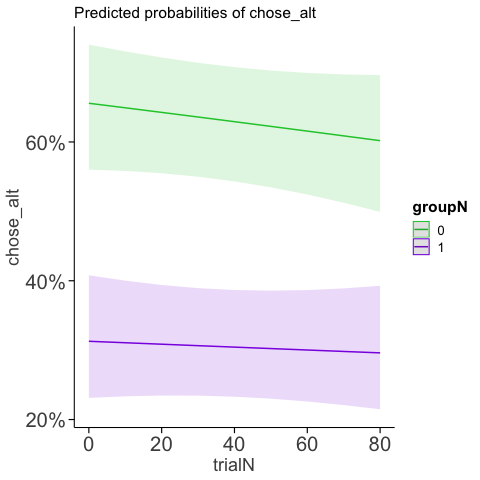

In [27]:
%%R -i choice_data_R
mod<-glmer(chose_alt ~ trialN * groupN + (1|subjid), family='binomial', data=choice_data_R)
print(summary(mod))
p <- plot_model(mod,type='eff',show.ci=F, show.values=T,p.kr=FALSE,terms=c('trialN','groupN'), color=cbPalette)
p

In [28]:
%%R
print(coef(summary(mod)))

                  Estimate  Std. Error    z value     Pr(>|z|)
(Intercept)    0.644627957 0.205480076  3.1371799 1.705814e-03
trialN        -0.002891133 0.002589928 -1.1162986 2.642943e-01
groupN        -1.431728077 0.294965451 -4.8538840 1.210666e-06
trialN:groupN  0.001904232 0.003744529  0.5085371 6.110767e-01


In [29]:
%%R
print(exp(coef(summary(mod))))

               Estimate Std. Error      z value Pr(>|z|)
(Intercept)   1.9052781   1.228115 23.038802702 1.001707
trialN        0.9971130   1.002593  0.327489723 1.302512
groupN        0.2388957   1.343080  0.007798031 1.000001
trialN:groupN 1.0019060   1.003752  1.662856893 1.842414


In [30]:
%%R
mod <- coef(summary(mod))
lower95 <- exp(mod[,'Estimate'] - (1.96*mod[,'Std. Error']))
upper95 <- exp(mod[,'Estimate'] + (1.96*mod[,'Std. Error']))
ci = data.frame(lower95,upper95)
print(ci)

                lower95   upper95
(Intercept)   1.2736503 2.8501423
trialN        0.9920643 1.0021875
groupN        0.1340074 0.4258808
trialN:groupN 0.9945797 1.0092864


Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: chose_alt ~ trialN + (1 | subjid)
   Data: choice_data_R
 Subset: (groupN == 0)

     AIC      BIC   logLik deviance df.resid 
  1902.8   1918.8   -948.4   1896.8     1559 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.8638 -0.8649  0.4349  0.7246  1.9800 

Random effects:
 Groups Name        Variance Std.Dev.
 subjid (Intercept) 0.8004   0.8947  
Number of obs: 1562, groups:  subjid, 21

Fixed effects:
             Estimate Std. Error z value Pr(>|z|)   
(Intercept)  0.649274   0.225540   2.879  0.00399 **
trialN      -0.002900   0.002598  -1.116  0.26427   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
       (Intr)
trialN -0.429


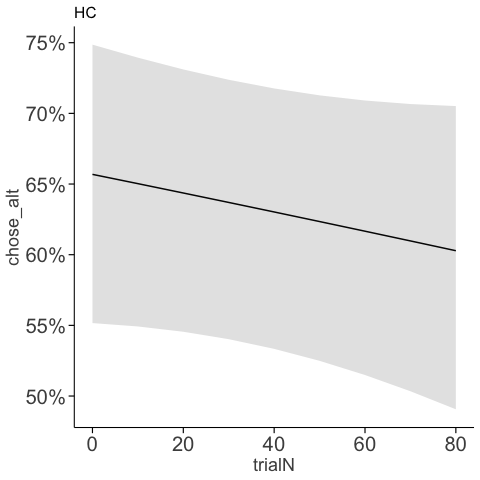

In [31]:
%%R -i choice_data_R
mod<-glmer(chose_alt ~ trialN + (1|subjid), family='binomial', data=choice_data_R, subset=(groupN==0))
print(summary(mod))
p <- plot_model(mod,type='eff',show.ci=F, show.values=T,p.kr=FALSE,terms=c('trialN'), title='HC')
p

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: chose_alt ~ trialN + (1 | subjid)
   Data: choice_data_R
 Subset: (groupN == 1)

     AIC      BIC   logLik deviance df.resid 
  1769.0   1784.9   -881.5   1763.0     1463 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.1363 -0.7469 -0.4972  1.0985  2.6456 

Random effects:
 Groups Name        Variance Std.Dev.
 subjid (Intercept) 0.4327   0.6578  
Number of obs: 1466, groups:  subjid, 20

Fixed effects:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.7791222  0.1877198  -4.150 3.32e-05 ***
trialN      -0.0009876  0.0026960  -0.366    0.714    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
       (Intr)
trialN -0.532


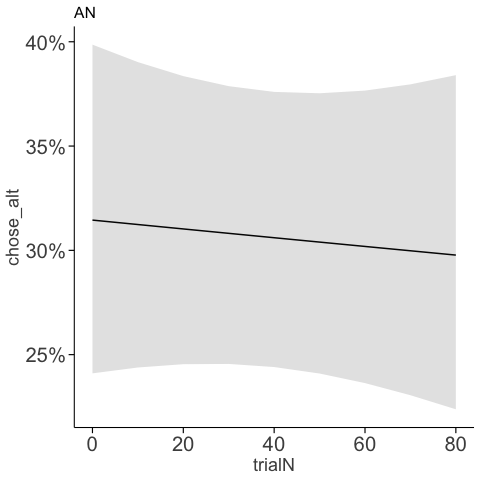

In [32]:
%%R -i choice_data_R
mod<-glmer(chose_alt ~ trialN + (1|subjid), family='binomial', data=choice_data_R, subset=(groupN==1))
print(summary(mod))
p <- plot_model(mod,type='eff',show.ci=F, show.values=T,p.kr=FALSE,terms=c('trialN'), title='AN')
p

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
choice_rating ~ trialN * alternative_taste * groupN + (alternative_taste |  
    subjid)
   Data: choice_data_R

REML criterion at convergence: 9697.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.9714 -0.6289 -0.0996  0.5607  3.2448 

Random effects:
 Groups   Name                         Variance Std.Dev. Corr 
 subjid   (Intercept)                  0.4184   0.6469        
          alternative_taste1_Not_Tasty 0.2616   0.5115   -0.32
 Residual                              1.3358   1.1558        
Number of obs: 3028, groups:  subjid, 41

Fixed effects:
                                             Estimate Std. Error         df
(Intercept)                                 4.120e+00  1.589e-01  5.096e+01
trialN                                     -1.186e-04  1.707e-03  2.948e+03
alternative_taste1_Not_Tasty               -1.679e+00  1.671e-01  1.070e+02
groupN               

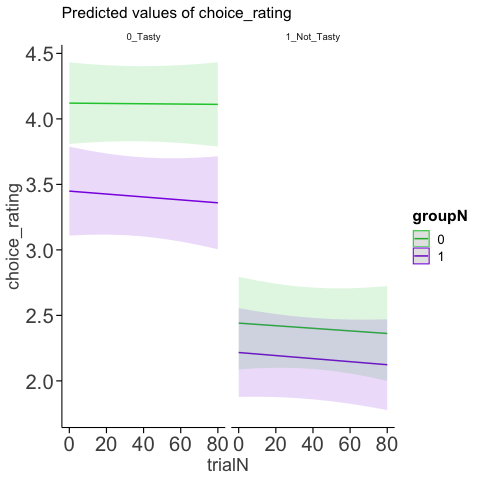

In [33]:
%%R -i choice_data_R
mod<-lmer(choice_rating ~ trialN * alternative_taste * groupN + (alternative_taste|subjid), data=choice_data_R)
print(summary(mod))
p <- plot_model(mod,type='eff',show.ci=F, show.values=T,p.kr=FALSE,terms=c('trialN','groupN','alternative_taste'), color=cbPalette)
p

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
choice_rating ~ trialN * alternative_health * groupN + (alternative_health |  
    subjid)
   Data: choice_data_R

REML criterion at convergence: 9976.1

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.95818 -0.69626  0.03215  0.74158  3.12195 

Random effects:
 Groups   Name                            Variance Std.Dev. Corr 
 subjid   (Intercept)                     0.3580   0.5984        
          alternative_health1_Not_Healthy 0.5354   0.7317   -0.38
 Residual                                 1.4593   1.2080        
Number of obs: 3028, groups:  subjid, 41

Fixed effects:
                                                Estimate Std. Error         df
(Intercept)                                    3.629e+00  1.596e-01  6.753e+01
trialN                                        -8.536e-04  2.147e-03  2.950e+03
alternative_health1_Not_Healthy               -1.274e-01  2.013e

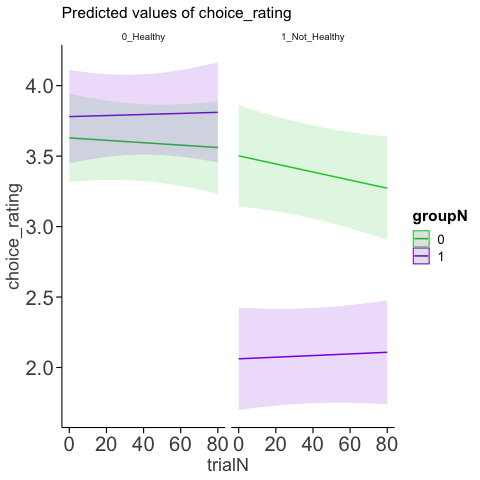

In [34]:
%%R -i choice_data_R
mod<-lmer(choice_rating ~ trialN * alternative_health * groupN + (alternative_health|subjid), data=choice_data_R)
print(summary(mod))
p <- plot_model(mod,type='eff',show.ci=F, show.values=T,p.kr=FALSE,terms=c('trialN','groupN','alternative_health'), color=cbPalette)
p

In [35]:
"""
Perform median split on ratings
Note: the median column in the returned dataframe is not exactly the median
The value returned in the median column is the rating number for the second bin (second_bin_starting_rating)
In the classification scripts, "low" class items have values less than second_bin_starting_rating
"high" class items have values greater than OR EQUAL to second_bin_starting_rating
"""
def get_rating_medians():
    subs = os.listdir('../behav')
    subs.sort()
    df = pd.DataFrame()
    ratings = ['taste_rating','health_rating']
    for subjid in subs:
        if subjid.startswith('sub-FCT'):
            for ratingType in ratings:
                behav_dir = os.path.join('..','behav')
                median = trial_class_median_split_py3.get_second_bin_starting_rating(subjid,ratingType,behav_dir)
                tmp = ratingType.split('_')
                label = tmp[0]
                if subjid.startswith('sub-FCT0'):
                    group = 'HC'
                else:
                    group = 'AN'
                df = df.append({'subjid':subjid,'group':group,'label':label,'median':median},ignore_index=True)
    return df

In [36]:
median_df = get_rating_medians()

In [37]:
# merge behavioral data (median_df) with imaging results (OFC_choices_df)
df = OFC_choices_df.merge(median_df,on=['subjid','label','group'])

In [38]:
# retrieve the specific food and choice rating on each trial
subs = os.listdir('../behav')
subs.sort()
ratings = ['taste_rating','health_rating']
ratingNames = {'taste_rating':'taste','health_rating':'health'}
for subjid in subs:
    if subjid.startswith('sub-FCT'):
        for ratingType in ratings:
            sub_df = df.loc[(df['subjid']==subjid) & (df['label']==ratingNames[ratingType])]
            if len(sub_df) > 0: # exception of 102, which was excluded because of missing anat image
                behav_dir = '../behav'
                choice_trials = trial_class_median_split_py3.get_choice_trials(subjid,behav_dir);
                choice_trials = choice_trials.loc[choice_trials['choice_rating']!=0]
                assert len(sub_df) == len(choice_trials)
                df.loc[(df['subjid']==subjid) & (df['label']==ratingNames[ratingType]),'food'] = choice_trials['food'].values
                df.loc[(df['subjid']==subjid) & (df['label']==ratingNames[ratingType]),'choice_rating'] = choice_trials['choice_rating'].values

In [39]:
OFC_choices_df = df

In [40]:
full_choice_data = OFC_choices_df.merge(choice_data,left_on=['subjid','food','group','choice_rating'],right_on=['subjid','food','group','choice_rating'])

In [41]:
full_choice_data = full_choice_data.rename(columns={'evidence of low rating':'evidence_of_low_rating','evidence of high rating':'evidence_of_high_rating'})

NOTE: median column refers to adjusted (after matching high/low bin sizes) median rating of the corresponding label (taste/health)
when label == taste, chosen_food_high_health_rating is meaningless
when label == health, chosen_food_high_taste_rating is meaningless
analyses are only conducted on taste_data and health_data, where the only correct columns are used

evidence_of_high_rating also corresponds to the label

In [42]:
full_choice_data['chosen_food_high_taste_rating'] = (full_choice_data['chosen_food_taste_rating'] >= full_choice_data['median']).astype(int)
full_choice_data['chosen_food_high_health_rating'] = (full_choice_data['chosen_food_health_rating'] >= full_choice_data['median']).astype(int)

In [43]:
full_choice_data['alt_taste_rating'] = full_choice_data['alt_taste_rating'].astype(int)
full_choice_data['alt_health_rating'] = full_choice_data['alt_health_rating'].astype(int)

In [44]:
full_choice_data['alt_food_high_taste_rating'] = (full_choice_data['alt_taste_rating'] >= full_choice_data['median']).astype(int)
full_choice_data['alt_food_high_health_rating'] = (full_choice_data['alt_health_rating'] >= full_choice_data['median']).astype(int)

# whether alternative item is tasty/healthy (not based on median split)
full_choice_data['alternative_taste'] = full_choice_data['alt_taste_rating'] > 3
full_choice_data['alternative_health'] = full_choice_data['alt_health_rating'] > 3
full_choice_data['alternative_taste'] = full_choice_data['alternative_taste'].replace({True:'0_Tasty',False:'1_Not_Tasty'})
full_choice_data['alternative_health'] = full_choice_data['alternative_health'].replace({True:'0_Healthy',False:'1_Not_Healthy'})

In [45]:
full_choice_data['last_half_trials'] = (full_choice_data['trialN'] > 74/2)

In [46]:
taste_data = full_choice_data.loc[full_choice_data['label']=='taste'].copy()
health_data = full_choice_data.loc[full_choice_data['label']=='health'].copy()

In [47]:
# remove items where alternative rating is missing
taste_data = taste_data.loc[taste_data['alt_taste_rating']!=0]
health_data = health_data.loc[health_data['alt_health_rating']!=0]

# remove choice trials with neutral rating (neither item was chosen)
taste_data = taste_data.loc[taste_data['choice_rating']!=3]
health_data = health_data.loc[health_data['choice_rating']!=3]

In [48]:
# check if high/low classifier evidence matches high/low label of chosen food
taste_data.loc[:,'predicted_taste_matches_chosen_food_taste'] = ((taste_data.loc[:,'evidence_of_high_rating']>=.5) == taste_data.loc[:,'chosen_food_high_taste_rating']).astype(int)*100
health_data.loc[:,'predicted_health_matches_chosen_food_health'] = ((health_data.loc[:,'evidence_of_high_rating']>=.5) == health_data.loc[:,'chosen_food_high_health_rating']).astype(int)*100

In [49]:
# check if high/low classifier evidence matches high/low label of alternative (trial-specific) food
taste_data.loc[:,'predicted_taste_matches_alt_food_taste'] = ((taste_data.loc[:,'evidence_of_high_rating']>=.5) == taste_data.loc[:,'alt_food_high_taste_rating']).astype(int)*100
health_data.loc[:,'predicted_health_matches_alt_food_health'] = ((health_data.loc[:,'evidence_of_high_rating']>=.5) == health_data.loc[:,'alt_food_high_health_rating']).astype(int)*100

number of choice trials, after removing choices with rating = 3 and removing choices where rating of alt food was not provided

In [50]:
taste_data.groupby(['subjid','group'],as_index=True).count().groupby(['group'],as_index=True).mean()[['trial']]

,trial
group,
AN,60.750000
HC,69.857143


In [51]:
taste_data.groupby(['subjid','group'],as_index=True).count().groupby(['group'],as_index=True).agg(np.std)[['trial']]

,trial
group,
AN,8.110260
HC,4.860923


In [52]:
v1 = taste_data.loc[taste_data['group']=='HC'].groupby(['subjid','group'],as_index=False).count()['trial']
v2 = taste_data.loc[taste_data['group']=='AN'].groupby(['subjid','group'],as_index=False).count()['trial']
stats.ttest_ind(v1,v2)

Ttest_indResult(statistic=4.3862165269869715, pvalue=8.488878882062863e-05)

In [53]:
health_data.groupby(['subjid','group'],as_index=True).count().groupby(['group'],as_index=True).mean()[['trial']]

,trial
group,
AN,61.350000
HC,70.285714


In [54]:
health_data.groupby(['subjid','group'],as_index=True).count().groupby(['group'],as_index=True).agg(np.std)[['trial']]

,trial
group,
AN,8.628441
HC,4.681270


In [55]:
v1 = health_data.loc[health_data['group']=='HC'].groupby(['subjid','group'],as_index=False).count()['trial']
v2 = health_data.loc[health_data['group']=='AN'].groupby(['subjid','group'],as_index=False).count()['trial']
stats.ttest_ind(v1,v2)

Ttest_indResult(statistic=4.1493095698460705, pvalue=0.00017478696506448882)

## Load ratings

In [56]:
subs = os.listdir('../behav')
subs.sort()
data = pd.DataFrame()
for sub in subs:
    if sub.startswith('sub-'):
        subfiles = os.listdir('../behav/'+sub)
        for f in subfiles:
            if '_h_' in f:
                health_file_name = f
            elif '_y_' in f:
                taste_file_name = f
        health = loadmat(os.path.join('..','behav',sub,health_file_name))
        taste = loadmat(os.path.join('..','behav',sub,taste_file_name))

        health_df = pd.DataFrame()
        health_df['food'] = np.concatenate(health['food'], axis=0)
        health_df['food'] = np.concatenate(health_df['food'], axis=0)
        health_df['health_rating'] = np.concatenate(health['health_rating'], axis=0)
        health_df['fat'] = np.concatenate(health['fat'], axis=0)

        taste_df = pd.DataFrame()
        taste_df['food'] = np.concatenate(taste['food'], axis=0)
        taste_df['food'] = np.concatenate(taste_df['food'], axis=0)
        taste_df['taste_rating'] = np.concatenate(taste['taste_rating'], axis=0)

        food_info = taste_df.merge(health_df,left_on='food',right_on='food')
        food_info['subjid'] = sub
        food_info['group'] = 'HC' if sub.startswith('sub-FCT0') else 'AN'
        data = pd.concat([data,food_info])
data['taste_rating'] = data['taste_rating'].replace({0:np.nan}) # remove trials without response
data['health_rating'] = data['health_rating'].replace({0:np.nan})

In [57]:
rating_data = data

#### get number of valid rating trials

##### taste ratings

In [58]:
taste_ratings = data[['group','subjid','taste_rating']]
taste_ratings = taste_ratings.loc[~np.isnan(taste_ratings['taste_rating'])]
taste_ratings = taste_ratings.groupby(['subjid','group'],as_index=False).count()

In [59]:
print('mean number of valid taste rating trials')
taste_ratings.groupby(['group'],as_index=False).mean()

mean number of valid taste rating trials


,group,taste_rating
0,AN,73.952381
1,HC,75.238095


In [60]:
print('std number of valid taste rating trials')
taste_ratings.groupby(['group'],as_index=False).agg(np.std)

std number of valid taste rating trials


,group,taste_rating
0,AN,4.200907
1,HC,1.179185


In [61]:
stats.ttest_ind(taste_ratings.loc[taste_ratings['group']=='HC','taste_rating'],taste_ratings.loc[taste_ratings['group']=='AN','taste_rating'])

Ttest_indResult(statistic=1.350337626615264, pvalue=0.18449882850439112)

##### health ratings

In [62]:
health_ratings = data[['group','subjid','health_rating']]
health_ratings = health_ratings.loc[~np.isnan(health_ratings['health_rating'])]
health_ratings = health_ratings.groupby(['subjid','group'],as_index=False).count()

In [63]:
print('mean number of valid health rating trials')
health_ratings.groupby(['group'],as_index=False).mean()

mean number of valid health rating trials


,group,health_rating
0,AN,74.380952
1,HC,75.571429


In [64]:
print('std number of valid health rating trials')
health_ratings.groupby(['group'],as_index=False).agg(np.std)

std number of valid health rating trials


,group,health_rating
0,AN,2.011870
1,HC,0.597614


In [65]:
stats.ttest_ind(health_ratings.loc[health_ratings['group']=='HC','health_rating'],health_ratings.loc[health_ratings['group']=='AN','health_rating'])

Ttest_indResult(statistic=2.599376224550181, pvalue=0.013018153906408592)

In [66]:
t_choice_data = taste_data.groupby(['subjid','group'],as_index=False).mean()[['subjid','group','chosen_food_high_taste_rating','choice_rating']]
t_choice_data['attribute'] = 'Tastiness'
t_choice_data.rename(columns={'chosen_food_high_taste_rating':'Chose higher rated food'},inplace=True)
h_choice_data = health_data.groupby(['subjid','group'],as_index=False).mean()[['subjid','group','chosen_food_high_health_rating','choice_rating']]
h_choice_data['attribute'] = 'Healthiness'
h_choice_data.rename(columns={'chosen_food_high_health_rating':'Chose higher rated food'},inplace=True)
choice_data_grouped = pd.concat([t_choice_data,h_choice_data])

### get group-level median ratings

In [67]:
data = rating_data

In [68]:
HC_med_ratings = data.loc[data['group']=='HC'].groupby(['subjid','group'],as_index=False).median()

In [69]:
HC_med_ratings.mean()[['taste_rating','health_rating']]

taste_rating     3.952381
health_rating    3.190476
dtype: float64

In [70]:
HC_med_ratings[['taste_rating','health_rating']].agg(np.std)

taste_rating     0.589592
health_rating    0.601585
dtype: float64

In [71]:
AN_med_ratings = data.loc[data['group']=='AN'].groupby(['subjid','group'],as_index=False).median()

In [72]:
AN_med_ratings.mean()[['taste_rating','health_rating']]

taste_rating     2.904762
health_rating    2.595238
dtype: float64

In [73]:
AN_med_ratings[['taste_rating','health_rating']].agg(np.std)

taste_rating     0.830949
health_rating    0.663684
dtype: float64

In [74]:
stats.ttest_ind(HC_med_ratings['taste_rating'],AN_med_ratings['taste_rating'])

Ttest_indResult(statistic=4.711882305659314, pvalue=2.951276901224152e-05)

In [75]:
stats.ttest_ind(HC_med_ratings['health_rating'],AN_med_ratings['health_rating'])

Ttest_indResult(statistic=3.0451596070881, pvalue=0.004102025979998826)

## Save data to csv files

In [76]:
if not os.path.exists('compiled_data_spreadsheets'):
    os.mkdir('compiled_data_spreadsheets')

#### save behavioral data to csv files

In [77]:
rating_data = rating_data[['subjid','group','food','taste_rating','health_rating']]
rating_data.reset_index(drop=True,inplace=True)
rating_data.to_csv('compiled_data_spreadsheets/rating_data.csv',index=False)

In [78]:
choice_data = choice_data[['subjid','group','ref_food','alt_food','choice_rating']]
choice_data.to_csv('compiled_data_spreadsheets/choice_rating_data.csv',index=False)

#### save within-task decoding scores to csv files

In [79]:
class_results.rename(columns={'Accuracy (%)':'within_task_decoding_accuracy',
                             'fmri_rsp':'rating_block_fmri_activity'},inplace=True)
class_results.drop(columns=['tag'],inplace=True)
class_results['within_task_decoding_accuracy'] = class_results['within_task_decoding_accuracy']
class_results = class_results.loc[(class_results['label']==class_results['rating_block_fmri_activity']) | (class_results['label']=='saturation')]
class_results.reset_index(drop=True,inplace=True)

In [80]:
perm_results.rename(columns={'fmri_rsp':'rating_block_fmri_activity',
                            'percentile_value':'percentile_95'
                            },inplace=True)
perm_results.drop(columns=['tag'],inplace=True)
perm_results = perm_results.loc[(perm_results['label']==perm_results['rating_block_fmri_activity']) | (perm_results['label']=='saturation')]
perm_results.reset_index(drop=True,inplace=True)

In [81]:
## rename column names for clarity
#column_dict = {}
#for i in range(0,1000):
#    column_dict[i] = 'permutation_test_iteration_%s'%(i)
#perm_results.rename(columns=column_dict,inplace=True)

In [82]:
perm_results.iloc[:,0:1000] = perm_results.iloc[:,0:1000].copy()
perm_results.loc[:,'percentile_value'] = perm_results.loc[:,'percentile_95'].copy()

In [83]:
class_results.to_csv('compiled_data_spreadsheets/within_task_decoding_accuracies.csv',index=False)

In [84]:
perm_results.to_csv('compiled_data_spreadsheets/within_task_decoding_permutation_scores.csv',index=False)

#### save choice decoding scores to csv files

In [85]:
taste_data_mod = taste_data.copy()
health_data_mod = health_data.copy()

In [86]:
# recode HC as 0 and AN as 1 for regression models
taste_data_mod['groupN']=taste_data_mod['group'].replace({'HC':0,'AN':1})
health_data_mod['groupN']=health_data_mod['group'].replace({'HC':0,'AN':1})

In [87]:
taste_data_mod = taste_data_mod[['subjid','groupN','group','label','chosen_food_high_taste_rating','choice_rating','evidence_of_high_rating','predicted_taste_matches_chosen_food_taste','predicted_taste_matches_alt_food_taste','alternative_taste','alternative_health','trialN','chose_alt','last_half_trials']]
health_data_mod = health_data_mod[['subjid','groupN','group','label','chosen_food_high_health_rating','choice_rating','evidence_of_high_rating','predicted_health_matches_chosen_food_health','predicted_health_matches_alt_food_health','alternative_taste','alternative_health','trialN','chose_alt','last_half_trials']]

In [88]:
taste_data_mod.rename(columns={'chosen_food_high_taste_rating':'chosen_food_high_rating',
                           'evidence_of_high_rating':'classifier_evidence',
                           'predicted_taste_matches_chosen_food_taste':'cross_task_accuracy',
                           'predicted_taste_matches_alt_food_taste':'cross_task_accuracy_alt'},inplace=True)
taste_data_mod.reset_index(drop=True,inplace=True)
taste_data_mod['cross_task_accuracy'] = taste_data_mod['cross_task_accuracy']/100 # rescale from 0-100 to 0-1
taste_data_mod['cross_task_accuracy_alt'] = taste_data_mod['cross_task_accuracy_alt']/100 # rescale from 0-100 to 0-1

In [89]:
health_data_mod = health_data_mod.copy()
health_data_mod.rename(columns={'chosen_food_high_health_rating':'chosen_food_high_rating',
                           'evidence_of_high_rating':'classifier_evidence',
                           'predicted_health_matches_chosen_food_health':'cross_task_accuracy',
                           'predicted_health_matches_alt_food_health':'cross_task_accuracy_alt'},inplace=True)
health_data_mod.reset_index(drop=True,inplace=True)
health_data_mod['cross_task_accuracy'] = health_data_mod['cross_task_accuracy']/100 # rescale from 0-100 to 0-1
health_data_mod['cross_task_accuracy_alt'] = health_data_mod['cross_task_accuracy_alt']/100 # rescale from 0-100 to 0-1

In [90]:
df = pd.concat([taste_data_mod,health_data_mod])

In [91]:
df.to_csv('compiled_data_spreadsheets/cross_task_decoding_accuracies.csv',index=False)

In [92]:
df = pd.read_csv('compiled_data_spreadsheets/cross_task_decoding_accuracies.csv')

## Plotting functions

In [93]:
"""
Plot null distribution

null_dist (dataframe row, [1 rows x 1000 columns]): null distribution
percentile_95 (float): 95th percentile of null distribution
sample_mean (float): sample mean of interest (cross-validation accuracy)
ax (matplotlib axes): axis to plot onto
x_pos (float): x coordinate indicating where to plot lie
markersize (float): length of line
markeredgewidth (float): thickness of line
color (string): color of null distribution (violin plot)
upright (boolean): if true, plot distribution upright, else plot downwards
condition (dictionary): for saving permutation test results, just ignore
"""

def plot_permutation_test_results_vert(null_dist,percentile_95,sample_mean,ax,x_pos,markersize,markeredgewidth,color,upright,condition={}):
    #ax.plot(x_pos, percentile_95, '_', color='gray',markersize=markersize,markeredgewidth=markeredgewidth,zorder=0)
    
    violin_parts = ax.violinplot(null_dist, positions=[x_pos], showextrema=False, widths=0.3, vert=True)

    for pc in violin_parts['bodies']:
        pc.set_facecolor(color)
        pc.set_zorder(0)
        
        # plot half of violin plot
        # https://stackoverflow.com/questions/29776114/half-violin-plot-in-matplotlib
        # get the center
        m = np.mean(pc.get_paths()[0].vertices[:, 0])
        
        if upright:
            # modify the paths to not go further left than the center
            pc.get_paths()[0].vertices[:, 0] = np.clip(pc.get_paths()[0].vertices[:, 0], -np.inf, m)
        else: 
            # modify the paths to not go further right than the center
            pc.get_paths()[0].vertices[:, 0] = np.clip(pc.get_paths()[0].vertices[:, 0], m, np.inf)
    
    perm_test = np.mean(null_dist > sample_mean)
    # print the proportion of values in the null distribution are greater than the sample mean
    print("permutation test:", perm_test)
    print('')

<a id='fig1'></a>
## Figure 1: Behavioral ratings and choices

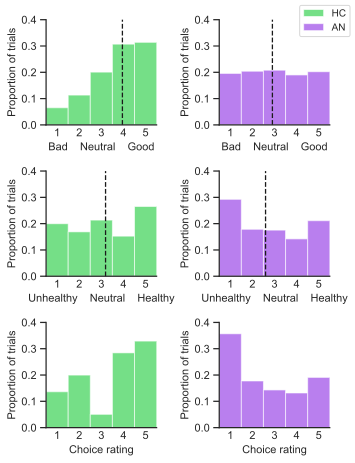

In [94]:
fig,axes = plt.subplots(3,2,sharex=False,figsize=(5,6.5),dpi=120)

data = rating_data

axes[0][0].hist(data.loc[data['group']=='HC','taste_rating'], density=True, bins=[1,2,3,4,5,6], align='left', color='g', alpha=0.6, label='HC')
axes[1][0].hist(data.loc[data['group']=='HC','health_rating'], density=True, bins=[1,2,3,4,5,6], align='left', color='g', alpha=0.6)
# get median rating for each subject
data_med = data.loc[data['group']=='HC'].groupby(['subjid','group'],as_index=False).median()
axes[0][0].axvline(data_med['taste_rating'].mean(), color='k', linestyle='dashed', linewidth=1.3)
# get median rating for each subject
data_med = data.loc[data['group']=='HC'].groupby(['subjid','group'],as_index=False).median()
axes[1][0].axvline(data_med['health_rating'].mean(), color='k', linestyle='dashed', linewidth=1.3)

axes[0][1].hist(data.loc[data['group']=='AN','taste_rating'], density=True, bins=[1,2,3,4,5,6], align='left', color='m',alpha=0.6,label='AN')
axes[1][1].hist(data.loc[data['group']=='AN','health_rating'], density=True, bins=[1,2,3,4,5,6], align='left', color='m',alpha=0.6)
# get median rating for each subject
data_med = data.loc[data['group']=='AN'].groupby(['subjid','group'],as_index=False).median()
axes[0][1].axvline(data_med['taste_rating'].mean(), color='k', linestyle='dashed', linewidth=1.3)
# get median rating for each subject
data_med = data.loc[data['group']=='AN'].groupby(['subjid','group'],as_index=False).median()
axes[1][1].axvline(data_med['health_rating'].mean(), color='k', linestyle='dashed', linewidth=1.3)

axes[2][0].hist(choice_data.loc[choice_data['group']=='HC','choice_rating'], density=True, bins=[1,2,3,4,5,6], align='left', color='g',alpha=0.6)
axes[2][1].hist(choice_data.loc[choice_data['group']=='AN','choice_rating'], density=True, bins=[1,2,3,4,5,6], align='left', color='m',alpha=0.6)

for ax in axes.flatten():
    ax.set_xticks(ticks=[1,2,3,4,5])
    ax.tick_params(axis='x',length=0)
    ax.set_ylim([0,0.4])
    ax.set_xlim([0.5,5.5])
    ax.set_yticks(ticks=[0,0.1,0.2,0.3,0.4])
    ax.tick_params(axis='both', which='major', labelsize=11)
    ax.set_ylabel('Proportion of trials',fontsize=11)
    
axes[0][0].set_xlabel('Bad    Neutral    Good',fontsize=11)
axes[0][1].set_xlabel('Bad    Neutral    Good',fontsize=11)
axes[1][0].set_xlabel('Unhealthy    Neutral    Healthy',fontsize=11)
axes[1][1].set_xlabel('Unhealthy    Neutral    Healthy',fontsize=11)

axes[2][0].set_xlabel('Choice rating',fontsize=11)
axes[2][1].set_xlabel('Choice rating',fontsize=11)

plt.suptitle('',fontsize=10,y=1.01)
fig.legend(fontsize=10)

plt.tight_layout()
sns.despine(top=True, right=True)

plt.savefig('FINAL_FIGURES/behavior_plots.png',bbox_inches='tight',dpi=500)
plt.savefig('FINAL_FIGURES/behavior_plots.svg',bbox_inches='tight',dpi=500)
plt.show()

<a id='fig2'></a>
## Figure 2: methods schematic  
![methods schematic](FINAL_FIGURES/methods_schematic_nb.png)

<a id='fig3abc'></a>
## Figure 3a-3c: Within-task classification

taste lOFC HC
permutation test: 0.001

taste mOFC HC
permutation test: 0.0

taste lOFC AN
permutation test: 0.0

taste mOFC AN
permutation test: 0.0

health lOFC HC
permutation test: 0.0

health mOFC HC
permutation test: 0.0

health lOFC AN
permutation test: 0.001

health mOFC AN
permutation test: 0.003

saturation from taste rating V1 HC
permutation test: 0.0

saturation from taste rating V1 AN
permutation test: 0.005



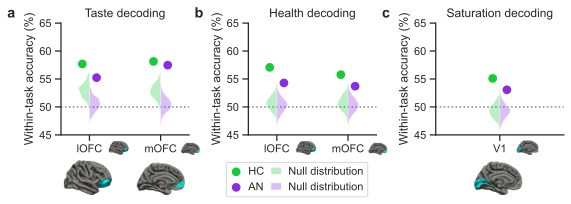

In [95]:
fig, axes = plt.subplots(1, 3, figsize=(8,3.4), sharex=False, dpi=120)
width = .1
dodge = .2
scale = 1

sns.set(style="ticks", palette="bright", color_codes=True, font_scale=1)

color_dict = {'HC':'#1ac938',
              'AN':'#8b2be2'}

### PLOT TASTE DECODING
data = class_results.loc[(class_results['label']=='taste') & (class_results['rating_block_fmri_activity']=='taste')].copy()
perm_data = perm_results.loc[(perm_results['label']=='taste') & (perm_results['rating_block_fmri_activity']=='taste')].copy()

sns.pointplot(y='within_task_decoding_accuracy', x='region', hue='group', palette=["g", "m"], order=['lOFC','mOFC'], 
              ci=None, scale=scale, dodge=dodge, join=False, data=data, ax=axes[0])
axes[0].get_legend().set_title('')

order = [{'region':'lOFC','group':'HC','x_pos_sig':0-width/4,'x_pos_perm':0},
         {'region':'mOFC','group':'HC','x_pos_sig':1-width/4,'x_pos_perm':1},
         {'region':'lOFC','group':'AN','x_pos_sig':0+width/4,'x_pos_perm':0},
         {'region':'mOFC','group':'AN','x_pos_sig':1+width/4,'x_pos_perm':1}]

for i in range(len(order)):
    region = order[i]['region']
    group = order[i]['group']
    # indicate significance
    subdata = data.loc[(data['region']==region) & (data['group']==group)].copy()
    
    print('taste', region, group)
    null_dist = perm_data.loc[(perm_data['group']==group) & (perm_data['region']==region)].copy()
    assert null_dist.shape == (1,1006)
    val = null_dist['percentile_value'].values[0]
    null_dist = null_dist[range(1000)] # remove misc. columns, just get values in null distribution
    assert null_dist.shape == (1,1000)
    null_dist = null_dist.values[0]
    
    upright = True if group == 'HC' else False
    plot_permutation_test_results_vert(null_dist,val,subdata['within_task_decoding_accuracy'].mean(),
                                  axes[0],order[i]['x_pos_perm'],15,2,color_dict[group],upright,
                                  {'label':'taste','fmri_rsp':'taste','tag':'ratings/objective','region':region,'group':group})
      
### PLOT HEALTH DECODING
data = class_results.loc[(class_results['label']=='health') & (class_results['rating_block_fmri_activity']=='health')].copy()
perm_data = perm_results.loc[(perm_results['label']=='health') & (perm_results['rating_block_fmri_activity']=='health')].copy()

sns.pointplot(y='within_task_decoding_accuracy', x='region', hue='group', palette=["g", "m"], order=['lOFC','mOFC'], 
              ci=None, scale=scale, dodge=dodge, join=False, data=data, ax=axes[1])
axes[1].get_legend().set_title('')

order = [{'region':'lOFC','group':'HC','x_pos_sig':0-width/4,'x_pos_perm':0},
         {'region':'mOFC','group':'HC','x_pos_sig':1-width/4,'x_pos_perm':1},
         {'region':'lOFC','group':'AN','x_pos_sig':0+width/4,'x_pos_perm':0},
         {'region':'mOFC','group':'AN','x_pos_sig':1+width/4,'x_pos_perm':1}]

for i in range(len(order)):
    region = order[i]['region']
    group = order[i]['group']
    # indicate significance
    subdata = data.loc[(data['region']==region) & (data['group']==group)].copy()
    
    print('health', region, group)
    null_dist = perm_data.loc[(perm_data['group']==group) & (perm_data['region']==region)].copy()
    assert null_dist.shape == (1,1006) 
    val = null_dist['percentile_value'].values[0]
    null_dist = null_dist[range(1000)] # remove misc. columns, just get values in null distribution
    assert null_dist.shape == (1,1000)
    null_dist = null_dist.values[0]
    
    upright = True if group == 'HC' else False
    plot_permutation_test_results_vert(null_dist,val,subdata['within_task_decoding_accuracy'].mean(),
                                  axes[1],order[i]['x_pos_perm'],15,2,color_dict[group],upright,
                                  {'label':'taste','fmri_rsp':'taste','tag':'ratings/objective','region':region,'group':group})
    
### PLOT SATURATION DECODING from tastiness rating
fmri_rsp = 'taste'
data = class_results.loc[(class_results['label']=='saturation') & (class_results['rating_block_fmri_activity']==fmri_rsp)].copy()
perm_data = perm_results.loc[(perm_results['label']=='saturation') & (perm_results['rating_block_fmri_activity']==fmri_rsp)].copy()

g = sns.pointplot(y='within_task_decoding_accuracy', x='region', hue='group', palette=["g", "m"],
                  ci=None, scale=scale, dodge=dodge, join=False, data=data)

order = [{'group':'HC','x_pos_sig':0-width/8,'x_pos_perm':0},
         {'group':'AN','x_pos_sig':0+width/8,'x_pos_perm':0}]

for i in range(len(order)):
    region = 'V1'
    group = order[i]['group']
    # indicate significance
    subdata = data.loc[(data['region']==region) & (data['group']==group)].copy()
    
    print('saturation from taste rating', region, group)
    null_dist = perm_data.loc[(perm_data['group']==group) & (perm_data['region']==region)].copy()
    assert null_dist.shape == (1,1006) 
    val = null_dist['percentile_value'].values[0]
    null_dist = null_dist[range(1000)] # remove misc. columns, just get values in null distribution
    assert null_dist.shape == (1,1000)
    null_dist = null_dist.values[0]
    
    upright = True if group == 'HC' else False
    plot_permutation_test_results_vert(null_dist,val,subdata['within_task_decoding_accuracy'].mean(),
                                  fig.gca(),order[i]['x_pos_perm'],15,2,color_dict[group], upright,
                                  {'label':'luminance','fmri_rsp':fmri_rsp,'tag':'visual_features','region':region,'group':group})

axes[0].axhline(y=50,linestyle=':',color='gray',zorder=-1)
axes[1].axhline(y=50,linestyle=':',color='gray',zorder=-1)
axes[2].axhline(y=50,linestyle=':',color='gray',zorder=-1)
axes[0].set_ylim(45,65)
axes[1].set_ylim(45,65)
axes[2].set_ylim(45,65)
axes[0].set_ylabel('Within-task accuracy (%)')
axes[1].set_ylabel('Within-task accuracy (%)')
axes[2].set_ylabel('Within-task accuracy (%)')
fig.align_xlabels()
axes[0].set_xlabel('')
axes[1].set_xlabel('')
axes[2].set_xlabel('')
axes[0].set_title('Taste decoding')
axes[1].set_title('Health decoding')
axes[2].set_title('Saturation decoding')

axes[0].get_legend().remove()
axes[2].get_legend().remove()
custom_lines = [Patch(facecolor='#baefc3ff'),
                Patch(facecolor='#dcbff7ff')]
handles, labels = axes[2].get_legend_handles_labels()
handles+=custom_lines
axes[1].legend(handles, ['HC','AN','Null distribution', 'Null distribution'], 
               ncol=2, handlelength=1, columnspacing=0.6,
               handletextpad=0.6,
               loc='center',
               bbox_to_anchor=(0.38, -0.4))
               #bbox_to_anchor=(0.38, -0.4))


sns.despine(top=True, right=True, ax=axes[0])
sns.despine(top=True, right=True, ax=axes[1])
sns.despine(top=True, right=True, ax=axes[2])

axes[0].set_xlim(-0.4,1.4)
axes[1].set_xlim(-0.4,1.4)
axes[2].set_xlim(-0.9,0.9)

axes[0].set_xticklabels(['lOFC','mOFC'])
axes[1].set_xticklabels(['lOFC','mOFC'])
axes[2].set_xticklabels(['V1'])

plt.tight_layout()

lpos0 = axes[0].transData.transform(axes[0].get_xticklabels()[0].get_position())[0] # lOFC x coord
mpos0 = axes[0].transData.transform(axes[0].get_xticklabels()[1].get_position())[0] # mOFC x coord
lpos1 = axes[1].transData.transform(axes[1].get_xticklabels()[0].get_position())[0] # lOFC x coord
mpos1 = axes[1].transData.transform(axes[1].get_xticklabels()[1].get_position())[0] # mOFC x coord
vpos2 = axes[2].transData.transform(axes[2].get_xticklabels()[0].get_position())[0] # V1 x coord

lposy0 = axes[0].transData.transform(axes[0].get_xticklabels()[0].get_position())[1] # lOFC y coord
mposy0 = axes[0].transData.transform(axes[0].get_xticklabels()[1].get_position())[1] # mOFC y coord
lposy1 = axes[1].transData.transform(axes[1].get_xticklabels()[0].get_position())[1] # lOFC y coord
mposy1 = axes[1].transData.transform(axes[1].get_xticklabels()[1].get_position())[1] # mOFC y coord
vposy2 = axes[2].transData.transform(axes[2].get_xticklabels()[0].get_position())[1] # V1 y coord

# dpi: 4-8
#https://stackoverflow.com/questions/3609585/how-to-insert-a-small-image-on-the-corner-of-a-plot-with-matplotlib
im = Image.open('FINAL_FIGURES/ROIs/lOFC_tiny.png')
width = im.size[0]
height = im.size[1]
im = np.array(im).astype(float) / 255
plt.plot(np.arange(10), np.arange(10))
fig.figimage(im, lpos0+width+2, 0-lposy0/3, zorder=100)

im = Image.open('FINAL_FIGURES/ROIs/mOFC_tiny.png')
width = im.size[0]
height = im.size[1]
im = np.array(im).astype(float) / 255
plt.plot(np.arange(10), np.arange(10))
fig.figimage(im, mpos0+width+6, 0-mposy0/3, zorder=100)

im = Image.open('FINAL_FIGURES/ROIs/lOFC_tiny.png')
width = im.size[0]
height = im.size[1]
im = np.array(im).astype(float) / 255
plt.plot(np.arange(10), np.arange(10))
fig.figimage(im, lpos1+width+2, 0-lposy1/3, zorder=100)

im = Image.open('FINAL_FIGURES/ROIs/mOFC_tiny.png')
width = im.size[0]
height = im.size[1]
im = np.array(im).astype(float) / 255
plt.plot(np.arange(10), np.arange(10))
fig.figimage(im, mpos1+width+6, 0-mposy1/3, zorder=100)

im = Image.open('FINAL_FIGURES/ROIs/V1_tiny.png')
width = im.size[0]
height = im.size[1]
im = np.array(im).astype(float) / 255
plt.plot(np.arange(10), np.arange(10))
fig.figimage(im, vpos2+width-6, 0-vposy2/3, zorder=100)


## LARGER ROIs
# dpi: 18
#https://stackoverflow.com/questions/3609585/how-to-insert-a-small-image-on-the-corner-of-a-plot-with-matplotlib
im = Image.open('FINAL_FIGURES/ROIs/lOFC.png')
width = im.size[0]
height = im.size[1]
im = np.array(im).astype(float) / 255
plt.plot(np.arange(10), np.arange(10))
fig.figimage(im, lpos0-width/2, -lposy0*0.06, zorder=100)

im = Image.open('FINAL_FIGURES/ROIs/mOFC.png')
width = im.size[0]
height = im.size[1]
im = np.array(im).astype(float) / 255
plt.plot(np.arange(10), np.arange(10))
fig.figimage(im, mpos0-width/2+3, -mposy0*0.06, zorder=100)

im = Image.open('FINAL_FIGURES/ROIs/V1.png')
width = im.size[0]
height = im.size[1]
im = np.array(im).astype(float) / 255
plt.plot(np.arange(10), np.arange(10))
fig.figimage(im, vpos2-width/2, -vposy2*0.06, zorder=100)

### ADD TEXT
axes[0].text(-0.42, 1.05, 'a', weight='bold', fontsize='large', transform=axes[0].transAxes)
axes[1].text(-0.42, 1.05, 'b', weight='bold', fontsize='large', transform=axes[1].transAxes)
axes[2].text(-0.42, 1.05, 'c', weight='bold', fontsize='large', transform=axes[2].transAxes)

fig.savefig('FINAL_FIGURES/taste_health_saturation_decoding.png', bbox_inches = "tight")
fig.savefig('FINAL_FIGURES/taste_health_saturation_decoding.svg', bbox_inches = "tight")
plt.show()

### Conduct permutation test to compare groups (for each ROI separately)

In [96]:
"""
Generic function for performing permutation test to compare cross-validation scores across groups/ROIs
Note output will vary each time because of random shuffling!

data: array of accuracy scores for both groups
n_data_in_group_1: number of data points in group 1 (HC)
diff: difference between groups that you're testing the permutation test against
"""
def do_perm_test(data,n_data_in_group_1,diff):
    acc = data['within_task_decoding_accuracy'].values
    perm_diff = np.zeros(1000)
    for i in range(0,1000): # 1000 shuffles
        random.shuffle(acc)
        fake_group1 = acc[0:n_data_in_group_1] # HC
        fake_group2 = acc[n_data_in_group_1:] # AN
        perm_diff[i] = fake_group1.mean() - fake_group2.mean()
    print('95th percentile:', np.quantile(perm_diff,0.95))
    print('p='+str(np.mean(perm_diff > diff)))
    return perm_diff

#### taste

In [97]:
data_m = class_results.loc[(class_results['label']=='taste') & (class_results['rating_block_fmri_activity']=='taste')]
data_m = data_m.groupby(['region','group'],as_index=False).mean()
data_m

,region,group,within_task_decoding_accuracy
0,lOFC,AN,55.239692
1,lOFC,HC,57.689362
2,mOFC,AN,57.472904
3,mOFC,HC,58.134921


In [98]:
'taste, lOFC: HC - AN',data_m.iloc[1]['within_task_decoding_accuracy'] - data_m.iloc[0]['within_task_decoding_accuracy']

('taste, lOFC: HC - AN', 2.4496699264501416)

In [99]:
'taste, mOFC: HC - AN',data_m.iloc[3]['within_task_decoding_accuracy'] - data_m.iloc[2]['within_task_decoding_accuracy']

('taste, mOFC: HC - AN', 0.6620165610103754)

#### taste, lOFC: HC > AN

In [100]:
data = class_results.loc[(class_results['label']=='taste') & (class_results['rating_block_fmri_activity']=='taste')]
data = data.loc[(data['region']=='lOFC')]
assert len(data) == 41
taste_lOFC_null_dist = do_perm_test(data,21,data_m.iloc[1]['within_task_decoding_accuracy'] - data_m.iloc[0]['within_task_decoding_accuracy'])

95th percentile: 4.342085372160574
p=0.188


#### taste, mOFC: HC > AN

In [101]:
data = class_results.loc[(class_results['label']=='taste') & (class_results['rating_block_fmri_activity']=='taste')]
data = data.loc[(data['region']=='mOFC')]
assert len(data) == 41
taste_mOFC_null_dist = do_perm_test(data,21,data_m.iloc[3]['within_task_decoding_accuracy'] - data_m.iloc[2]['within_task_decoding_accuracy'])

95th percentile: 3.652700861046183
p=0.412


#### health

In [102]:
data_m = class_results.loc[(class_results['label']=='health') & (class_results['rating_block_fmri_activity']=='health')]
data_m = data_m.groupby(['region','group'],as_index=False).mean()
data_m

,region,group,within_task_decoding_accuracy
0,lOFC,AN,54.291366
1,lOFC,HC,57.076720
2,mOFC,AN,53.709150
3,mOFC,HC,55.774854


In [103]:
'health, lOFC: HC - AN',data_m.iloc[1]['within_task_decoding_accuracy'] - data_m.iloc[0]['within_task_decoding_accuracy']

('health, lOFC: HC - AN', 2.7853539076449465)

In [104]:
'health, mOFC: HC - AN',data_m.iloc[3]['within_task_decoding_accuracy'] - data_m.iloc[2]['within_task_decoding_accuracy']

('health, mOFC: HC - AN', 2.0657034743722207)

#### health, lOFC: HC > AN

In [105]:
data = class_results.loc[(class_results['label']=='health') & (class_results['rating_block_fmri_activity']=='health')]
data = data.loc[(data['region']=='lOFC')]
assert len(data) == 41
health_lOFC_null_dist = do_perm_test(data,21,data_m.iloc[1]['within_task_decoding_accuracy'] - data_m.iloc[0]['within_task_decoding_accuracy'])

95th percentile: 4.519313500253905
p=0.164


#### health, mOFC: HC > AN

In [106]:
data = class_results.loc[(class_results['label']=='health') & (class_results['rating_block_fmri_activity']=='health')]
data = data.loc[(data['region']=='mOFC')]
assert len(data) == 41
health_mOFC_null_dist = do_perm_test(data,21,data_m.iloc[3]['within_task_decoding_accuracy'] - data_m.iloc[2]['within_task_decoding_accuracy'])

95th percentile: 3.8912963577243755
p=0.2


### conduct permutation test to compare decoding accuracy across subregions

#### taste

In [107]:
data = class_results.loc[(class_results['label']=='taste') & (class_results['rating_block_fmri_activity']=='taste')]
assert len(data) == 82
data_m = data.groupby(['region'],as_index=False).mean()
data_m

,region,within_task_decoding_accuracy
0,lOFC,56.494401
1,mOFC,57.811986


In [108]:
'taste, lOFC-mOFC',data_m.iloc[0]['within_task_decoding_accuracy'] - data_m.iloc[1]['within_task_decoding_accuracy']

('taste, lOFC-mOFC', -1.3175843722169986)

In [109]:
data = class_results.loc[(class_results['label']=='taste') & (class_results['rating_block_fmri_activity']=='taste')]
assert len(data) == 82
taste_region_null_dist = do_perm_test(data,41,data_m.iloc[0]['within_task_decoding_accuracy'] - data_m.iloc[1]['within_task_decoding_accuracy'])

95th percentile: 2.8098687057193343
p=0.758


#### health

In [110]:
data = class_results.loc[(class_results['label']=='health') & (class_results['rating_block_fmri_activity']=='health')]
assert len(data) == 82
data_m = data.groupby(['region'],as_index=False).mean()
data_m

,region,within_task_decoding_accuracy
0,lOFC,55.718010
1,mOFC,54.767194


In [111]:
'health, lOFC-mOFC',data_m.iloc[0]['within_task_decoding_accuracy'] - data_m.iloc[1]['within_task_decoding_accuracy']

('health, lOFC-mOFC', 0.950816783709648)

In [112]:
data = class_results.loc[(class_results['label']=='health') & (class_results['rating_block_fmri_activity']=='health')]
assert len(data) == 82
health_region_null_dist = do_perm_test(data,41,data_m.iloc[0]['within_task_decoding_accuracy'] - data_m.iloc[1]['within_task_decoding_accuracy'])

95th percentile: 2.9363835821020765
p=0.312


### conduct permutation test to compare decoding accuracies between groups

#### taste

In [113]:
data = class_results.loc[(class_results['label']=='taste') & (class_results['rating_block_fmri_activity']=='taste')]
assert len(data) == 82
data_m = data.groupby(['group'],as_index=False).mean()
data_m

,group,within_task_decoding_accuracy
0,AN,56.356298
1,HC,57.912141


In [114]:
'taste, HC-AN',data_m.iloc[1]['within_task_decoding_accuracy'] - data_m.iloc[0]['within_task_decoding_accuracy']

('taste, HC-AN', 1.5558432437302656)

In [115]:
data = class_results.loc[(class_results['label']=='taste') & (class_results['rating_block_fmri_activity']=='taste')]
assert len(data) == 82
taste_group_null_dist = do_perm_test(data,41,data_m.iloc[1]['within_task_decoding_accuracy'] - data_m.iloc[0]['within_task_decoding_accuracy'])

95th percentile: 2.801036246762287
p=0.193


#### health

In [116]:
data = class_results.loc[(class_results['label']=='health') & (class_results['rating_block_fmri_activity']=='health')]
assert len(data) == 82
data_m = data.groupby(['group'],as_index=False).mean()
data_m

,group,within_task_decoding_accuracy
0,AN,54.000258
1,HC,56.425787


In [117]:
'health, HC-AN',data_m.iloc[1]['within_task_decoding_accuracy'] - data_m.iloc[0]['within_task_decoding_accuracy']

('health, HC-AN', 2.425528691008587)

In [118]:
data = class_results.loc[(class_results['label']=='health') & (class_results['rating_block_fmri_activity']=='health')]
assert len(data) == 82
health_group_null_dist = do_perm_test(data,41,data_m.iloc[1]['within_task_decoding_accuracy'] - data_m.iloc[0]['within_task_decoding_accuracy'])

95th percentile: 2.908958191749111
p=0.085


#### saturation from taste rating activity

In [119]:
data = class_results.loc[(class_results['label']=='saturation') & (class_results['rating_block_fmri_activity']=='taste')]
assert len(data) == 41
data_m = data.groupby(['group'],as_index=False).mean()
data_m

,group,within_task_decoding_accuracy
0,AN,53.063842
1,HC,55.099554


In [120]:
'taste, HC-AN',data_m.iloc[1]['within_task_decoding_accuracy'] - data_m.iloc[0]['within_task_decoding_accuracy']

('taste, HC-AN', 2.0357122381116284)

In [121]:
data = class_results.loc[(class_results['label']=='saturation') & (class_results['rating_block_fmri_activity']=='taste')]
assert len(data) == 41
taste_group_null_dist = do_perm_test(data,21,data_m.iloc[1]['within_task_decoding_accuracy'] - data_m.iloc[0]['within_task_decoding_accuracy'])

95th percentile: 3.734349149016339
p=0.183


#### saturation from health rating activity

In [122]:
data = class_results.loc[(class_results['label']=='saturation') & (class_results['rating_block_fmri_activity']=='health')]
assert len(data) == 41
data_m = data.groupby(['group'],as_index=False).mean()
data_m

,group,within_task_decoding_accuracy
0,AN,53.323873
1,HC,53.794208


In [123]:
'health, HC-AN',data_m.iloc[1]['within_task_decoding_accuracy'] - data_m.iloc[0]['within_task_decoding_accuracy']

('health, HC-AN', 0.47033433256341795)

In [124]:
data = class_results.loc[(class_results['label']=='saturation') & (class_results['rating_block_fmri_activity']=='health')]
assert len(data) == 41
health_group_null_dist = do_perm_test(data,21,data_m.iloc[1]['within_task_decoding_accuracy'] - data_m.iloc[0]['within_task_decoding_accuracy'])

95th percentile: 3.68270451455436
p=0.403


<a id='fig5a'></a>
## Figure 5a: Predict choice rating from taste classifier evidence

In [125]:
%%R -i taste_data_mod
taste_mod=lmer(choice_rating ~ classifier_evidence * groupN * alternative_taste + (classifier_evidence|subjid), data=taste_data_mod)
print(summary(taste_mod))

R[write to console]: boundary (singular) fit: see ?isSingular



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: choice_rating ~ classifier_evidence * groupN * alternative_taste +  
    (classifier_evidence | subjid)
   Data: taste_data_mod

REML criterion at convergence: 8723.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.9976 -0.6143 -0.1237  0.6352  3.3102 

Random effects:
 Groups   Name                Variance Std.Dev. Corr 
 subjid   (Intercept)         0.46329  0.68065       
          classifier_evidence 0.00977  0.09884  -1.00
 Residual                     1.44555  1.20231       
Number of obs: 2682, groups:  subjid, 41

Fixed effects:
                                                         Estimate Std. Error
(Intercept)                                                3.9602     0.2191
classifier_evidence                                        0.4156     0.3554
groupN                                                    -0.3804     0.3531
alternative_taste1_Not_Tasty          

In [126]:
%%R
mod <- coef(summary(taste_mod))
lower95 <- mod[,'Estimate'] - (1.96*mod[,'Std. Error'])
upper95 <- mod[,'Estimate'] + (1.96*mod[,'Std. Error'])
ci = data.frame(lower95,upper95)
print(ci)

                                                            lower95    upper95
(Intercept)                                              3.53076420  4.3895807
classifier_evidence                                     -0.28101322  1.1121787
groupN                                                  -1.07251821  0.3117478
alternative_taste1_Not_Tasty                            -2.05501039 -1.2975582
classifier_evidence:groupN                              -1.89676241  0.3499980
classifier_evidence:alternative_taste1_Not_Tasty        -1.08753297  0.5660470
groupN:alternative_taste1_Not_Tasty                     -0.02518739  1.1393566
classifier_evidence:groupN:alternative_taste1_Not_Tasty -1.34097677  1.0126907


<a id='fig5b'></a>
## Figure 5b: Predict choice rating from health classifier evidence

In [127]:
%%R -i health_data_mod
health_mod=lmer(choice_rating ~ classifier_evidence * groupN * alternative_health + (classifier_evidence|subjid), data=health_data_mod)
print(summary(health_mod))

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: choice_rating ~ classifier_evidence * groupN * alternative_health +  
    (classifier_evidence | subjid)
   Data: health_data_mod

REML criterion at convergence: 9119.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.7864 -0.6107  0.0024  0.7121  3.0788 

Random effects:
 Groups   Name                Variance Std.Dev. Corr 
 subjid   (Intercept)         1.051    1.025         
          classifier_evidence 2.973    1.724    -0.80
 Residual                     1.629    1.276         
Number of obs: 2703, groups:  subjid, 41

Fixed effects:
                                                             Estimate
(Intercept)                                                   3.77990
classifier_evidence                                          -0.41181
groupN                                                       -1.02490
alternative_health1_Not_Healthy                              -0.

In [128]:
%%R
mod <- coef(summary(health_mod))
lower95 <- mod[,'Estimate'] - (1.96*mod[,'Std. Error'])
upper95 <- mod[,'Estimate'] + (1.96*mod[,'Std. Error'])
ci = data.frame(lower95,upper95)
print(ci)

                                                              lower95
(Intercept)                                                 3.0760937
classifier_evidence                                        -1.7757292
groupN                                                     -2.1936615
alternative_health1_Not_Healthy                            -0.6212873
classifier_evidence:groupN                                  0.2873696
classifier_evidence:alternative_health1_Not_Healthy        -0.8017252
groupN:alternative_health1_Not_Healthy                     -0.7719994
classifier_evidence:groupN:alternative_health1_Not_Healthy -4.8601406
                                                              upper95
(Intercept)                                                 4.4837019
classifier_evidence                                         0.9521011
groupN                                                      0.1438544
alternative_health1_Not_Healthy                             0.1964148
classifier_evidence:

<a id='fig5'></a>
## Figure 5: Classifier evidence and choices

##### Note: choice classification analyses were conducted on entire OFC (lOFC + mOFC) because within-task classification performance didn't differ between lOFC and mOFC

In [129]:
# just plot binned data for alternative==tasty or alternative==healthy
tasty_data = taste_data_mod.loc[taste_data_mod['alternative_taste']=='0_Tasty'].copy()
healthy_data = health_data_mod.loc[health_data_mod['alternative_health']=='0_Healthy'].copy()

# create 4 bins: (-0.001, 0.25], (0.25, 0.5], (0.5, 0.75], (0.75, 1.0]
nbins = 4

# sort each data point into each bin
for sub in tasty_data.subjid.unique():
    ev_values = tasty_data.loc[tasty_data['subjid']==sub,'classifier_evidence']
    bins = pd.qcut(np.linspace(0, 1, nbins), nbins)
    uniq_bins = bins.unique()
    uniq_bins = np.sort(uniq_bins)
    for i in range(len(uniq_bins)):
        b = uniq_bins[i]
        # add bin interval as column
        tasty_data.loc[(tasty_data['subjid']==sub) & (tasty_data['classifier_evidence']>b.left) & (tasty_data['classifier_evidence']<=b.right),'ev_bin'] = b
        # get classifier evidence for each bin
        bin_data = tasty_data.loc[(tasty_data['subjid']==sub) & (tasty_data['ev_bin']==b),'classifier_evidence']
        # set mean classifier evidence in each bin
        tasty_data.loc[(tasty_data['subjid']==sub) & (tasty_data['ev_bin']==b),'bin_mean'] = bin_data.mean()
        # number each bin
        tasty_data.loc[(tasty_data['subjid']==sub) & (tasty_data['ev_bin']==b),'binN'] = i

for sub in healthy_data.subjid.unique():
    ev_values = healthy_data.loc[healthy_data['subjid']==sub,'classifier_evidence']
    bins = pd.qcut(np.linspace(0, 1, nbins), nbins)
    uniq_bins = bins.unique()
    uniq_bins = np.sort(uniq_bins)
    for i in range(len(uniq_bins)):
        b = uniq_bins[i]
        # add bin interval as column
        healthy_data.loc[(healthy_data['subjid']==sub) & (healthy_data['classifier_evidence']>b.left) & (healthy_data['classifier_evidence']<=b.right),'ev_bin'] = b
        # get classifier evidence for each bin
        bin_data = healthy_data.loc[(healthy_data['subjid']==sub) & (healthy_data['ev_bin']==b),'classifier_evidence']
        # set mean classifier evidence in each bin
        healthy_data.loc[(healthy_data['subjid']==sub) & (healthy_data['ev_bin']==b),'bin_mean'] = bin_data.mean()
        # number each bin
        healthy_data.loc[(healthy_data['subjid']==sub) & (healthy_data['ev_bin']==b),'binN'] = i

In [130]:
# calculate means for each bins and calculate sem for each bin
dataT = tasty_data.groupby(['group','subjid','bin_mean','binN'],as_index=False).mean()
dataT_m = dataT.groupby(['group','binN'],as_index=False).mean()
dataT_count = dataT.groupby(['group','binN'],as_index=False).count() # get number of subjects in each bin
dataT_std = dataT.groupby(['group','binN'],as_index=False).std()
dataT_std['choice_rating'] = dataT_std['choice_rating']/np.sqrt(dataT_count['choice_rating'])
assert np.array_equal(dataT_m['group'],dataT_std['group'])
assert np.array_equal(dataT_m['binN'],dataT_std['binN'])
dataT_m['choice_rating_sem'] = dataT_std['choice_rating']

# average data across bins and calculate sem for each bin
dataH = healthy_data.groupby(['group','subjid','bin_mean','binN'],as_index=False).mean()
dataH_m = dataH.groupby(['group','binN'],as_index=False).mean()
dataH_count = dataH.groupby(['group','binN'],as_index=False).count() # get number of subjects in each bin
dataH_std = dataH.groupby(['group','binN'],as_index=False).std()
dataH_std['choice_rating'] = dataH_std['choice_rating']/np.sqrt(dataH_count['choice_rating'])
assert np.array_equal(dataH_m['group'],dataH_std['group'])
assert np.array_equal(dataH_m['binN'],dataH_std['binN'])
dataH_m['choice_rating_sem'] = dataH_std['choice_rating']

In [131]:
HC_dataT = dataT_m.loc[dataT_m['group']=='HC']
AN_dataT = dataT_m.loc[dataT_m['group']=='AN']

HC_dataH = dataH_m.loc[dataH_m['group']=='HC']
AN_dataH = dataH_m.loc[dataH_m['group']=='AN']

HC, taste
Ttest_1sampResult(statistic=5.265645736516241, pvalue=1.8717449305598546e-05) 21
AN, taste
Ttest_1sampResult(statistic=0.5262964506577242, pvalue=0.3023860817234779) 20
Ttest_indResult(statistic=0.9755326858859072, pvalue=0.3353085599450967)
HC, health
Ttest_1sampResult(statistic=2.5616561186119435, pvalue=0.009302138980186992) 21
AN, health
Ttest_1sampResult(statistic=2.4413345929043304, pvalue=0.012295382645028516) 20
Ttest_indResult(statistic=-0.9258988393307784, pvalue=0.36019289623130524)


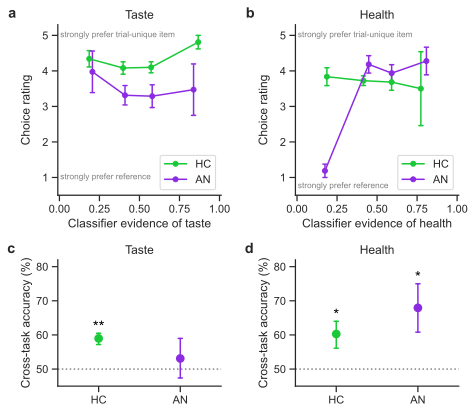

In [132]:
fig = plt.figure(dpi=400,figsize=(6.8,5.9))

widths = [1, 1]
heights = [1.35, 1]
gs = fig.add_gridspec(ncols=2, nrows=2, width_ratios=widths,
                          height_ratios=heights)
    
##### ROW 1
ax_taste = fig.add_subplot(gs[0, 0])
plt.title('Taste')

ax_taste.set_xlim((-0.01, 1.01))
ax_taste.set_ylim((0.5, 5.3))

ax_health = fig.add_subplot(gs[0, 1])
plt.title('Health')

ax_health.set_xlim((-0.01, 1.01))
ax_health.set_ylim((0.5, 5.3))

ax_taste.set_xlabel('Classifier evidence of taste')
ax_taste.set_ylabel('Choice rating')

ax_health.set_xlabel('Classifier evidence of health')
ax_health.set_ylabel('Choice rating')

ms = 5 # marker size
cs = 2 # cap size
ew = 1.5 # error bar width
ct = ew # cap thickness

green = "#1ac938"
purple = "#8b2be2"

_, caps, _ = ax_taste.errorbar(HC_dataT['bin_mean'], HC_dataT['choice_rating'], yerr=HC_dataT['choice_rating_sem'], 
                                                color=green, markerfacecolor=green,
                                                capsize=cs, marker='o',label="HC", markersize=ms, elinewidth=ew, capthick=ew)
for cap in caps:
    cap._marker._capstyle = "round"

_, caps, _ = ax_taste.errorbar(AN_dataT['bin_mean'], AN_dataT['choice_rating'], yerr=AN_dataT['choice_rating_sem'], 
                                                color=purple, markerfacecolor=purple,
                                                capsize=cs, marker='o',label="AN", markersize=ms, elinewidth=ew, capthick=ew)
for cap in caps:
    cap._marker._capstyle = "round"
    
_, caps, _ = ax_health.errorbar(HC_dataH['bin_mean'], HC_dataH['choice_rating'], yerr=HC_dataH['choice_rating_sem'], 
                                                 color=green, markerfacecolor=green,
                                                 capsize=cs, marker='o',label="HC", markersize=ms, elinewidth=ew, capthick=ew)
for cap in caps:
    cap._marker._capstyle = "round"
    
_, caps, _ = ax_health.errorbar(AN_dataH['bin_mean'], AN_dataH['choice_rating'], yerr=AN_dataH['choice_rating_sem'], 
                                                 color=purple, markerfacecolor=purple,
                                                 capsize=cs, marker='o',label="AN", markersize=ms, elinewidth=ew, capthick=ew)
for cap in caps:
    cap._marker._capstyle = "round"
    
ax_taste.set_xticks(np.linspace(0, 1, 5))
ax_health.set_xticks(np.linspace(0, 1, 5))

ax_taste.spines['right'].set_visible(False)
ax_taste.spines['top'].set_visible(False)
ax_health.spines['right'].set_visible(False)
ax_health.spines['top'].set_visible(False)

handles, labels = ax_taste.get_legend_handles_labels()
handles = [h[0] for h in handles]
labels = ['HC','AN']
ax_taste.legend(handles=handles, labels=labels, loc='lower right')

handles, labels = ax_health.get_legend_handles_labels()
handles = [h[0] for h in handles]
labels = ['HC','AN']
ax_health.legend(handles=handles, labels=labels, loc='lower right')

##### ROW 2
taste_data_m = taste_data_mod.groupby(['subjid','group','label'],as_index=False).mean()
health_data_m = health_data_mod.groupby(['subjid','group','label'],as_index=False).mean()
taste_data_m['cross_task_accuracy'] = taste_data_m['cross_task_accuracy']*100 # rescale to 0-100
health_data_m['cross_task_accuracy'] = health_data_m['cross_task_accuracy']*100 # rescale to 0-100
tmp1 = taste_data_m.loc[(taste_data_m['label']=='taste')&(taste_data_m['group']=='HC'),'cross_task_accuracy']
tmp2 = taste_data_m.loc[(taste_data_m['label']=='taste')&(taste_data_m['group']=='AN'),'cross_task_accuracy']
print('HC, taste')
ttest = stats.ttest_1samp(tmp1,50,alternative='greater')
print(ttest, len(tmp1))
print('AN, taste')
ttest = stats.ttest_1samp(tmp2,50,alternative='greater')
print(ttest, len(tmp2))
print(stats.ttest_ind(tmp1,tmp2))

tmp1 = health_data_m.loc[(health_data_m['label']=='health')&(health_data_m['group']=='HC'),'cross_task_accuracy']
tmp2 = health_data_m.loc[(health_data_m['label']=='health')&(health_data_m['group']=='AN'),'cross_task_accuracy']
print('HC, health')
ttest = stats.ttest_1samp(tmp1,50,alternative='greater')
print(ttest, len(tmp1))
print('AN, health')
ttest = stats.ttest_1samp(tmp2,50,alternative='greater')
print(ttest, len(tmp2))
print(stats.ttest_ind(tmp1,tmp2))

ax_taste_ctrl = fig.add_subplot(gs[1, 0])
plt.title('Taste')
sns.pointplot(x='group',y='cross_task_accuracy',palette=["g", "m"],order=['HC','AN'],join=False,errwidth=ew,capsize=cs/40,
              ci=68,dodge=.2,scale=1,data=taste_data_m,ax=ax_taste_ctrl)

ax_health_ctrl = fig.add_subplot(gs[1, 1])
plt.title('Health')
sns.pointplot(x='group',y='cross_task_accuracy',palette=["g", "m"],order=['HC','AN'],join=False,errwidth=ew,capsize=cs/40,
              ci=68,dodge=.2,scale=1,data=health_data_m,ax=ax_health_ctrl)

#ax_taste_ctrl.text(0,61,'**',fontsize=15,color='black',ha='center')
#ax_health_ctrl.text(0,65,'*',fontsize=15,color='black',ha='center')
#ax_health_ctrl.text(1,75.5,'*',fontsize=15,color='black',ha='center')

ax_taste_ctrl.text(0,ax_taste_ctrl.get_lines()[2].get_ydata()[1]+.5,
                   '**',fontsize=15,color='black',ha='center')
ax_health_ctrl.text(0,ax_health_ctrl.get_lines()[2].get_ydata()[1]+.5,
                    '*',fontsize=15,color='black',ha='center')
ax_health_ctrl.text(1,ax_health_ctrl.get_lines()[-1].get_ydata()[1]+.5,
                    '*',fontsize=15,color='black',ha='center')

ax_taste_ctrl.set_ylabel('Cross-task accuracy (%)')
ax_health_ctrl.set_ylabel('Cross-task accuracy (%)')
ax_taste_ctrl.set_xlabel('')
ax_health_ctrl.set_xlabel('')
ax_taste_ctrl.axhline(50,linestyle=':',zorder=0,color='gray')
ax_health_ctrl.axhline(50,linestyle=':',zorder=0,color='gray')

ax_taste_ctrl.set_ylim([45,82])
ax_health_ctrl.set_ylim([45,82])

ax_taste_ctrl.spines['right'].set_visible(False)
ax_taste_ctrl.spines['top'].set_visible(False)
ax_health_ctrl.spines['right'].set_visible(False)
ax_health_ctrl.spines['top'].set_visible(False)


### ADD TEXT
ax_taste.text(0.005, 1-0.05, "strongly prefer reference", color='gray', fontsize='x-small')
ax_taste.text(0.005, 5-0.05, "strongly prefer trial-unique item", color='gray', fontsize='x-small')
ax_health.text(0.005, 1-0.3, "strongly prefer reference", color='gray', fontsize='x-small')
ax_health.text(0.005, 5-0.05, "strongly prefer trial-unique item", color='gray', fontsize='x-small')
ax_taste.text(-0.32, 5.5, 'a', weight='bold', fontsize='large')
ax_health.text(-0.32, 5.5, 'b', weight='bold', fontsize='large')
ax_taste_ctrl.text(-1.12, 84, 'c', weight='bold', fontsize='large')
ax_health_ctrl.text(-1.12, 84, 'd', weight='bold', fontsize='large')

fig.align_ylabels()
plt.tight_layout()

plt.savefig('FINAL_FIGURES/choice_and_evidence.png', bbox_inches = "tight", dpi=500)
plt.savefig('FINAL_FIGURES/choice_and_evidence.svg', bbox_inches = "tight", dpi=500)
plt.show()

### compare cross-task decoding using taste/health of choice item vs. alternative item

In [133]:
taste_data_m = taste_data_mod.groupby(['subjid','group','label'],as_index=False).mean()
health_data_m = health_data_mod.groupby(['subjid','group','label'],as_index=False).mean()
taste_data_m['cross_task_accuracy'] = taste_data_m['cross_task_accuracy']*100 # rescale to 0-100
health_data_m['cross_task_accuracy'] = health_data_m['cross_task_accuracy']*100 # rescale to 0-100
taste_data_m['cross_task_accuracy_alt'] = taste_data_m['cross_task_accuracy_alt']*100 # rescale to 0-100
health_data_m['cross_task_accuracy_alt'] = health_data_m['cross_task_accuracy_alt']*100 # rescale to 0-100

tmp1 = taste_data_m[['subjid','cross_task_accuracy_alt','group','label']].copy()
tmp2 = taste_data_m[['subjid','cross_task_accuracy','group','label']].copy()
tmp1['Accuracy'] = tmp1['cross_task_accuracy_alt']
tmp2['Accuracy'] = tmp2['cross_task_accuracy']
tmp1['choice_comparison'] = 'Alternative food'
tmp2['choice_comparison'] = 'Chosen food'
data = pd.concat([tmp1,tmp2])
choice_decode_df = data

tmp1 = health_data_m[['subjid','cross_task_accuracy_alt','group','label']].copy()
tmp2 = health_data_m[['subjid','cross_task_accuracy','group','label']].copy()
tmp1['Accuracy'] = tmp1['cross_task_accuracy_alt']
tmp2['Accuracy'] = tmp2['cross_task_accuracy']
tmp1['choice_comparison'] = 'Alternative food'
tmp2['choice_comparison'] = 'Chosen food'
data = pd.concat([tmp1,tmp2])

choice_decode_df = pd.concat([choice_decode_df,data])
# deviation coding
choice_decode_df.replace({'taste':-1,'health':1},inplace=True)
choice_decode_df.replace({'HC':-1,'AN':1},inplace=True)

In [134]:
%%R -i choice_decode_df
cmod = lmer(Accuracy ~ choice_comparison * label * group + (1|subjid), data = choice_decode_df)
print(summary(cmod))

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: Accuracy ~ choice_comparison * label * group + (1 | subjid)
   Data: choice_decode_df

REML criterion at convergence: 1356.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.4375 -0.2737  0.0658  0.3988  2.4387 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjid   (Intercept)  43.7     6.611  
 Residual             244.4    15.632  
Number of obs: 164, groups:  subjid, 41

Fixed effects:
                                         Estimate Std. Error      df t value
(Intercept)                                54.070      2.012  87.781  26.874
choice_comparisonChosen food                6.006      2.442 117.000   2.459
label                                      -0.204      1.727 117.000  -0.118
group                                      -2.157      2.012  87.781  -1.072
choice_comparisonChosen food:label          4.238      2.442 117.000   1.736
choice_comparisonChosen

#### control analysis to test whether left/right responses were being decoded

R[write to console]: boundary (singular) fit: see ?isSingular



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: chose_alt ~ classifier_evidence * groupN + (classifier_evidence |  
    subjid)
   Data: taste_data_mod

     AIC      BIC   logLik deviance df.resid 
  3203.3   3244.5  -1594.6   3189.3     2675 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.5036 -0.8369  0.2918  0.8009  2.8879 

Random effects:
 Groups Name                Variance Std.Dev. Corr
 subjid (Intercept)         0.4730   0.6878       
        classifier_evidence 0.2593   0.5092   1.00
Number of obs: 2682, groups:  subjid, 41

Fixed effects:
                           Estimate Std. Error z value Pr(>|z|)  
(Intercept)                  0.4178     0.3119   1.340   0.1804  
classifier_evidence          0.8233     0.6426   1.281   0.2001  
groupN                      -0.5334     0.4846  -1.101   0.2710  
classifier_evidence:groupN  -1.5934     0.9269  -1.719   0.0856 .
---
Signif. 

R[write to console]: Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



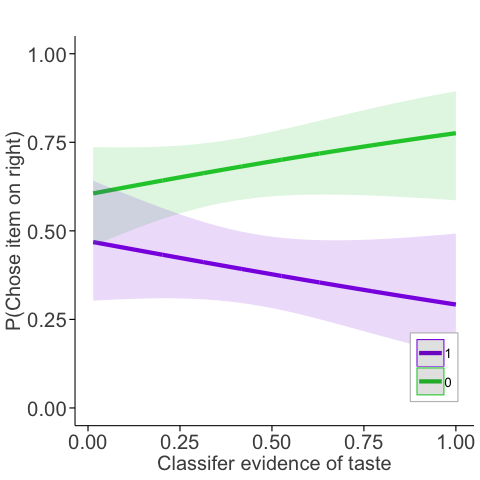

In [135]:
%%R -i taste_data_mod

taste_mod=glmer(chose_alt ~ classifier_evidence * groupN + (classifier_evidence|subjid), family='binomial', data=taste_data_mod)
print(summary(taste_mod))
taste_plot <- plot_model(taste_mod,type='eff',show.ci=F, show.values=T,p.kr=FALSE,terms=c('classifier_evidence [all]','groupN'),axis.lim=c(0,1),color=cbPalette,line.size=2,legend.title='') +
    labs(title="",y="P(Chose item on right)", x="Classifer evidence of taste") + 
    scale_color_manual(values=cbPalette,guide = guide_legend(reverse = TRUE)) + 
    scale_fill_manual(values=cbPalette) + 
    theme(legend.key = element_rect(fill = 'white'), axis.title=element_text(size=20,), title=element_text(size=20,hjust = 0.5), 
          legend.title=element_text(size=0,), legend.background = element_rect(colour = "grey"), 
          legend.key.size = unit(1, "cm"), legend.position = c(0.9, 0.15))
    
taste_plot

In [136]:
%%R
print(coef(summary(taste_mod)))

                             Estimate Std. Error   z value   Pr(>|z|)
(Intercept)                 0.4178317  0.3119079  1.339600 0.18037557
classifier_evidence         0.8233189  0.6426024  1.281226 0.20011426
groupN                     -0.5334035  0.4845730 -1.100770 0.27099669
classifier_evidence:groupN -1.5934347  0.9268922 -1.719115 0.08559335


In [137]:
%%R
print(exp(coef(summary(taste_mod))))

                            Estimate Std. Error   z value Pr(>|z|)
(Intercept)                1.5186650   1.366029 3.8175145 1.197667
classifier_evidence        2.2780479   1.901423 3.6010523 1.221542
groupN                     0.5866051   1.623482 0.3326148 1.311271
classifier_evidence:groupN 0.2032264   2.526645 0.1792246 1.089363


In [138]:
%%R
mod <- coef(summary(taste_mod))
lower95 <- exp(mod[,'Estimate'] - (1.96*mod[,'Std. Error']))
upper95 <- exp(mod[,'Estimate'] + (1.96*mod[,'Std. Error']))
ci = data.frame(lower95,upper95)
print(ci)

                              lower95  upper95
(Intercept)                0.82406340 2.798745
classifier_evidence        0.64650024 8.027070
groupN                     0.22691801 1.516431
classifier_evidence:groupN 0.03303646 1.250163


#### control analysis to test whether left/right responses were being decoded

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: chose_alt ~ classifier_evidence * groupN + (classifier_evidence |  
    subjid)
   Data: health_data_mod

     AIC      BIC   logLik deviance df.resid 
  3234.6   3275.9  -1610.3   3220.6     2696 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.7892 -0.8360  0.3210  0.8077  2.6462 

Random effects:
 Groups Name                Variance Std.Dev. Corr 
 subjid (Intercept)         1.747    1.322         
        classifier_evidence 5.018    2.240    -0.74
Number of obs: 2703, groups:  subjid, 41

Fixed effects:
                           Estimate Std. Error z value Pr(>|z|)  
(Intercept)                 0.76764    0.51661   1.486    0.137  
classifier_evidence        -0.04604    1.02322  -0.045    0.964  
groupN                     -1.37208    0.83168  -1.650    0.099 .
classifier_evidence:groupN  0.22211    1.59362   0.139    0.889  
---
Sign

R[write to console]: Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



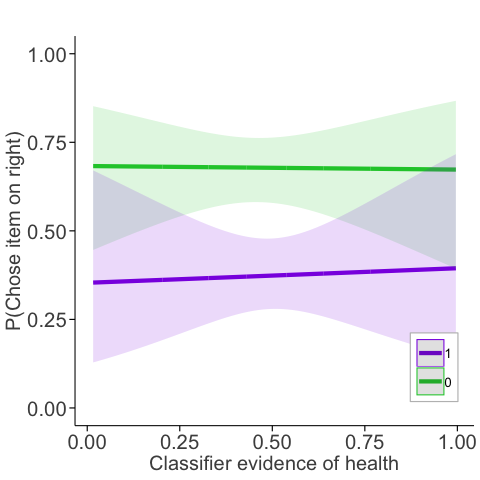

In [139]:
%%R -i health_data_mod
### Plot chose_health_item as function of health evidence
health_mod=glmer(chose_alt ~ classifier_evidence * groupN + (classifier_evidence|subjid), family='binomial', data=health_data_mod)
print(summary(health_mod))
health_plot <- plot_model(health_mod,type='eff',show.ci=F, show.values=T,p.kr=FALSE,terms=c('classifier_evidence [all]','groupN'),axis.lim=c(0,1),color=cbPalette,line.size=2,legend.title='') + 
    labs(title="",y="P(Chose item on right)", x="Classifier evidence of health") + 
    scale_color_manual(values=cbPalette,guide = guide_legend(reverse = TRUE)) + 
    scale_fill_manual(values=cbPalette) + 
    theme(legend.key = element_rect(fill = 'white'), axis.title=element_text(size=20,), title=element_text(size=20,hjust = 0.5), 
          legend.title=element_text(size=0,), legend.background = element_rect(colour = "grey"), 
          legend.key.size = unit(1, "cm"), legend.position = c(0.9, 0.15))

health_plot 

In [140]:
%%R
print(coef(summary(health_mod)))

                              Estimate Std. Error     z value   Pr(>|z|)
(Intercept)                 0.76764325  0.5166062  1.48593489 0.13729634
classifier_evidence        -0.04604294  1.0232187 -0.04499814 0.96410880
groupN                     -1.37208076  0.8316816 -1.64976694 0.09899061
classifier_evidence:groupN  0.22210786  1.5936230  0.13937290 0.88915549


In [141]:
%%R
print(exp(coef(summary(health_mod))))

                            Estimate Std. Error   z value Pr(>|z|)
(Intercept)                2.1546822   1.676329 4.4190949 1.147168
classifier_evidence        0.9550010   2.782135 0.9559993 2.622449
groupN                     0.2535788   2.297178 0.1920947 1.104056
classifier_evidence:groupN 1.2487061   4.921547 1.1495527 2.433074


In [142]:
%%R
mod <- coef(summary(health_mod))
lower95 <- exp(mod[,'Estimate'] - (1.96*mod[,'Std. Error']))
upper95 <- exp(mod[,'Estimate'] + (1.96*mod[,'Std. Error']))
ci = data.frame(lower95,upper95)
print(ci)

                              lower95   upper95
(Intercept)                0.78277890  5.930992
classifier_evidence        0.12853531  7.095536
groupN                     0.04967882  1.294358
classifier_evidence:groupN 0.05494662 28.377850


### Compare within-task decoding accuracies for HC subjects with median = 5 and median < 5

In [143]:
median_data = median_df.loc[median_df['label']=='taste'].groupby(['subjid'],as_index=False).mean()[['subjid','median']]

In [144]:
data = class_results.loc[(class_results['label']=='taste') & (class_results['rating_block_fmri_activity']=='taste')]
perm_data = perm_results.loc[(perm_results['label']=='taste') & (perm_results['rating_block_fmri_activity']=='taste')]

In [145]:
data = data.merge(median_data)

In [146]:
data['median5'] = data['median'] == 5

In [147]:
data.groupby(['group','median5','region']).count()

within_task_decoding_accuracy  \
group median5 region                                  
AN    False   lOFC                               19   
              mOFC                               19   
      True    lOFC                                1   
              mOFC                                1   
HC    False   lOFC                               11   
              mOFC                               11   
      True    lOFC                               10   
              mOFC                               10   

                      rating_block_fmri_activity  label  subjid  median  
group median5 region                                                     
AN    False   lOFC                            19     19      19      19  
              mOFC                            19     19      19      19  
      True    lOFC                             1      1       1       1  
              mOFC                             1      1       1       1  
HC    False   lOFC                            11     11      11      11  
              mOFC                            11     11      11      11  
      True    lOFC                            10     10      10      10  
              mOFC                            10     10      10      10

In [148]:
data.groupby(['group','median5','region']).mean()

within_task_decoding_accuracy    median
group median5 region                                         
AN    False   lOFC                        54.797371  3.473684
              mOFC                        57.014822  3.473684
      True    lOFC                        63.643791  5.000000
              mOFC                        66.176471  5.000000
HC    False   lOFC                        53.728070  4.000000
              mOFC                        55.077087  4.000000
      True    lOFC                        62.046784  5.000000
              mOFC                        61.498538  5.000000

In [149]:
tmp1 = data.loc[(data['label']=='taste') & (data['median5'] == True) & (data['group']=='HC'),'within_task_decoding_accuracy']
tmp2 = data.loc[(data['label']=='taste') & (data['median5'] == False) & (data['group']=='HC'),'within_task_decoding_accuracy']
stats.ttest_ind(tmp1,tmp2)

Ttest_indResult(statistic=3.134000177825199, pvalue=0.0032243374425871885)

In [150]:
# perform a permutation
diff = tmp1.mean() - tmp2.mean() # sample difference between means for HC participants with median == 5 and median < 5 (across both ROIs)
n_data_in_group_1 = 20
acc = data.loc[(data['label']=='taste') & (data['group']=='HC'),'within_task_decoding_accuracy'].values
perm_diff = np.zeros(1000)
for i in range(0,1000): # 1000 shuffles
    random.shuffle(acc)
    fake_group1 = acc[0:n_data_in_group_1] # median5
    fake_group2 = acc[n_data_in_group_1:] # median5
    perm_diff[i] = fake_group1.mean() - fake_group2.mean()
print('95th percentile:', np.quantile(perm_diff,0.95))
print('p='+str(np.mean(perm_diff > diff)))

95th percentile: 4.370381446039354
p=0.0


### Control analysis to look at null distributions for individuals with skewed taste ratings

In [151]:
"""
Get permutation test scores for within-task classification on subject by subject basis

dir_path (string): path to output files
tag (string): for identifying the outputs
region (string): ROI (lOFC, mOFC, etc)
"""
def get_permutation_test_95_percentile_per_sub(dir_path,tag,region):
    files = os.listdir(dir_path)
    files.sort()
    all_perm_data = {}
    subjids = {}
    for f in files:
        fileinfo = f.split('_')
        subjid = fileinfo[0] # e.g. sub-FCT001
        label = fileinfo[2] 
        fmriresponse = fileinfo[4]
        if subjid.startswith('sub-FCT0'):
            group = 'HC'
        else:
            group = 'AN'
        condition = 'predict_'+label+'_from_'+fmriresponse
        contents = open(os.path.join(dir_path,f), 'r')
        perm_scores=contents.read().splitlines()
        perm_scores = np.asarray(perm_scores).astype(float)
        perm_scores = perm_scores*100
        perm_scores = list(perm_scores)
        if condition not in all_perm_data.keys():
            all_perm_data[condition] = {}
            subjids[condition] = {}
        if group not in all_perm_data[condition].keys():
            all_perm_data[condition][group] = perm_scores
            subjids[condition][group] = []
        else:
            all_perm_data[condition][group] = np.vstack((all_perm_data[condition][group],perm_scores))
        subjids[condition][group].append(subjid)
    
    dists = pd.DataFrame()
    for condition in all_perm_data.keys():
        for group in all_perm_data[condition].keys():
            df = pd.DataFrame(all_perm_data[condition][group])
            df['subjid'] = subjids[condition][group]
            df['group'] = group
            df['condition'] = condition
            _, label, _, fmrirsp = condition.split('_')
            df['label'] = label
            df['fmrirsp'] = fmrirsp
            dists = pd.concat([dists,df])
    return dists

In [152]:
lOFC_perm_df = get_permutation_test_95_percentile_per_sub('cross_val_scores_model-003/cross_val_scores_permutation_results_lOFC','ratings/objective','lOFC')
mOFC_perm_df = get_permutation_test_95_percentile_per_sub('cross_val_scores_model-003/cross_val_scores_permutation_results_mOFC','ratings/objective','mOFC')

In [153]:
lOFC_perm_df = lOFC_perm_df.loc[(lOFC_perm_df['condition']=='predict_taste_from_taste') | (lOFC_perm_df['condition']=='predict_health_from_health')]
mOFC_perm_df = mOFC_perm_df.loc[(mOFC_perm_df['condition']=='predict_taste_from_taste') | (mOFC_perm_df['condition']=='predict_health_from_health')]

In [154]:
lOFC_perm_df['ROI'] = 'lOFC'
mOFC_perm_df['ROI'] = 'mOFC'

In [155]:
full_perm_df = pd.concat([lOFC_perm_df,mOFC_perm_df])

In [156]:
full_perm_df = full_perm_df.merge(median_df,on=['subjid','label','group'])
full_perm_df['skewed_ratings'] = full_perm_df['median']==5
full_perm_df.to_csv('./compiled_data_spreadsheets/within_task_decoding_individual_subj_permutation_scores.csv')

ignore permutation test output
(10, 1008)
permutation test: 1.0

(11, 1008)
permutation test: 1.0

(10, 1008)
permutation test: 1.0

(11, 1008)
permutation test: 1.0

(1, 1008)
permutation test: 1.0

(19, 1008)
permutation test: 1.0

(1, 1008)
permutation test: 1.0

(19, 1008)
permutation test: 1.0



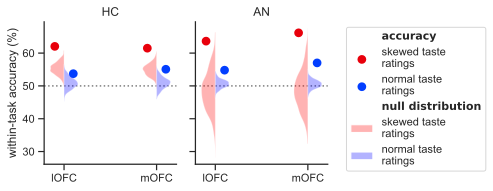

In [157]:
label='taste'
data = class_results.loc[(class_results['label']==label) & (class_results['rating_block_fmri_activity']==label)].copy()
data = data.merge(median_df,on=['subjid','label','group'])
data['skewed_ratings'] = data['median']==5

g = sns.catplot(kind='point',col='group',x='region',y='within_task_decoding_accuracy',
                hue_order=[True,False],
                hue='skewed_ratings',
                ci=None,
                join=False,
                dodge=0.2,
                palette=['r','b'],
                height=3,aspect=0.8,
                legend=False,
                data=data)
axes = g.axes[0]

print('ignore permutation test output')

axes[0].axhline(y=50,linestyle=':',color='gray',zorder=-1)
axes[1].axhline(y=50,linestyle=':',color='gray',zorder=-1)

order = [{'region':'lOFC','x_pos_sig':0,'x_pos_perm':0},
         {'region':'mOFC','x_pos_sig':1,'x_pos_perm':1}]

groups = ['HC','AN']

for j in range(len(groups)):
    group = groups[j]
    for i in range(len(order)):
        region = order[i]['region']
        upright=True
        perm_df = full_perm_df.loc[full_perm_df['ROI']==region]
        perm_df = perm_df.loc[perm_df['group']==group]

        null_dist = perm_df.loc[(perm_df['label']==label) & (perm_df['median']==5)] # participants with skewed taste ratings
        print(null_dist.shape)
        null_dist = null_dist.iloc[:,0:1000].mean(axis=0)
        assert null_dist.shape == (1000,)
        plot_permutation_test_results_vert(null_dist,0,0,
                                      axes[j],order[i]['x_pos_sig'],15,2,'red',upright,
                                      {})
        null_dist = perm_df.loc[(perm_df['label']==label) & (perm_df['median']!=5)] # participants with roughly normally distributed taste ratings
        print(null_dist.shape)
        null_dist = null_dist.iloc[:,0:1000].mean(axis=0)
        assert null_dist.shape == (1000,)
        upright=False
        plot_permutation_test_results_vert(null_dist,0,0,
                                  axes[j],order[i]['x_pos_sig'],15,2,'blue',upright,
                                  {})
        
axes[0].set_ylabel('within-task accuracy (%)')
custom_lines = [Patch(facecolor='#ffb3b3'),
                Patch(facecolor='#b3b3ff')]
handles, labels = axes[1].get_legend_handles_labels()
handles = [Rectangle((0,0), 0, 0, color='w')] + handles + [Rectangle((0,0), 0, 0, color='w')]
handles+=custom_lines
plt.legend(handles, ['$\\bf{accuracy}$',
                    'skewed taste\nratings','normal taste\nratings',
                    '$\\bf{null \ distribution}$',
                     'skewed taste\nratings', 'normal taste\nratings'], bbox_to_anchor=[1.1,1])

g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.set(xlabel=None)
plt.savefig('./FINAL_FIGURES/skewed_null_distributions.png', bbox_inches = "tight", dpi=500)
plt.show()